# Stratification Linked to Seasonality in Eddy Subduction in the Southern Ocean

Chen and Schofield, 2024

Analysis and figures

## Import packages

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cmx
import matplotlib.ticker as mticker
import matplotlib.lines as lines
import seaborn as sns
from PIL import Image

import scipy as sp
from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression

import xarray as xr
import numpy as np
import math
import itertools

import gsw as gsw

import cartopy as cp
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from datetime import datetime
from datetime import timedelta

import glob
import warnings

import pandas as pd
%matplotlib inline

from tqdm import tqdm
import subprocess

### Import SOCCOM float data
* 2023-08-28 Data snapshot downloaded from https://library.ucsd.edu/dc/collection/bb0488375t
* Format: LIAR carbon algorithm, netCDF, low resolution 


In [3]:
floatspath = 'SOCCOM_GO-BGC_LoResQC_LIAR_28Aug2023_netcdf'

In [4]:
floats = pd.read_csv('{}/MBARI_float_list.txt'.format(floatspath),sep='\t')

In [5]:
so_floats = [] # A list of only floats that traveled <-30 latitude

for i in floats.WMO.to_list():
    if i in [i[-12:-5] for i in glob.glob('{}/{}QC.nc'.format(floatspath,i))]: # only floats that have QC nc files
        db = xr.open_dataset('{}/{}QC.nc'.format(floatspath, i))
        if db.Lat.min() <= -30:
            so_floats.append(i)

### Import front locations
Park Young-Hyang, Durand Isabelle (2019). Altimetry-drived Antarctic Circumpolar Current fronts. SEANOE. https://doi.org/10.17882/59800

In [6]:
fronts = xr.open_dataset('orsi_park-durand_so_fronts_.nc')

## Differentiate between NAVIS floats (more frequent sampling) and other floats

In [7]:
# Lists of different float types
navis_floats = floats[floats['float type']=='NAVIS'].WMO.to_list()
apex_floats = floats[floats['float type']=='APEX'].WMO.to_list()

In [8]:
apex_schedule = np.concatenate((np.arange(5,105,5),np.arange(110,370,10),np.arange(380,400,20),np.arange(400,1010,50))) # List of APEX sampling depths

In [9]:
solo = []
apex = []
navis = []

for floatid in so_floats:
    db = xr.open_dataset('{}/{}QC.nc'.format(floatspath,floatid))
    depth_interval = np.ediff1d(db.Depth[0][np.where(db.Depth[0]<600)]).mean() # Average depth interval between 0-600 m

    if floats[floats['WMO']==floatid]['float type'].item() == 'SOLO':
        solo.append(depth_interval)
    elif floats[floats['WMO']==floatid]['float type'].item() == 'APEX':
        apex.append(depth_interval)
    elif floats[floats['WMO']==floatid]['float type'].item() == 'NAVIS':
        navis.append(depth_interval)

#print('Median depth interval between 0-600 m:')
#print('Navis floats: ',np.median(navis))
#print('Apex floats: ',np.median(apex))

In [10]:
solo = []
apex = []
navis = []

for floatid in so_floats:
    db = xr.open_dataset('{}/{}QC.nc'.format(floatspath, floatid))
    depth_interval = np.ediff1d(db.Depth[0][np.where((db.Depth[0]<600)&(db.Depth[0]>0))]).mean() # Average depth interval between 0-600 m

    if floats[floats['WMO']==floatid]['float type'].item() == 'SOLO':
        solo.append(depth_interval)
    elif floats[floats['WMO']==floatid]['float type'].item() == 'APEX':
        apex.append(depth_interval)
    elif floats[floats['WMO']==floatid]['float type'].item() == 'NAVIS':
        navis.append(depth_interval)

print('Median depth interval between 0-600 m:')
print('Navis floats: ',np.median(navis))
print('Apex floats: ',np.median(apex))

Median depth interval between 0-600 m:
Navis floats:  -1.978734219269103
Apex floats:  -11.53456862745098


## Functions: MLD and N2
Analysis functions used to generate derived data used in plots

### MLD: density threshold method

In [11]:
def mld05(dens,dens_QFA):
    """
    Calculates depth pycnocline using the max of buoyancy frequency method
     It calculates MLD per profile
     It outputs depth_MLD, index_MLD and the Quality index
     It requires as input: 
         1. density (2D matrix: N_PROF x N_LEVELS)
    """
    
    #===========================================
    # Flag profiles that are >50% bad QC 
    num_invalid = np.count_nonzero(dens_QFA.isin([8]), axis=1) #Per profile (axis=1), count the number of readings with QC flags of 8 (bad). Returns an n-length array. Each value is the number of bad readings
    half_levels = (np.count_nonzero(~np.isnan(dens), axis=1))/2 #Half the number of *valid* readings per profile
    invalid_profiles = np.where(num_invalid/half_levels>0.5)[0] #The indices of profiles with >50% invalid readings
    
    #===========================================
    # Initialize variables to hold output
    MLD_n = np.empty(np.shape(dens)[0]) #Array to hold the calculated MLD for each profile (length N-profiles)
    MLD_n[:] = np.nan # Initialize the array with nans
    
    #===========================================

    indices_MLDs = np.zeros(dens.shape[0])+np.nan # Initialize an all-nan array the length of N_PROF (dens.shape[0])
    
    for i in range(len(dens)): # For each profile
        #if dens[i][np.isnan(dens[i])==False][-1].Depth < 30: # If surface-most profile is shallower than 15 m deep (ignore profiles that didn't surface higher than that)
        if i not in invalid_profiles and len(dens[i][~np.isnan(dens[i])])>0: # If the profile isn't all NaN
            dens_prof = dens[i]  # Get just the current density profile
            dens_prof = dens_prof[np.isnan(dens_prof)==False] # Remove NANs
            
            
            surfacediff = dens_prof[:]-dens_prof[-1].item() # Calculate the difference from the surface density 
            if np.any(surfacediff>0.05): # Skip profiles where there's no density gradient > 0.05     
                MLD = surfacediff.where(surfacediff>0.05,drop=True)[-1].Depth.item() # MLD is the shallowest depth where density difference from surface > 0.05 kg/m3
                MLD_index = np.where(dens[i].Depth==MLD)[0][0] # Return the index of the MLD within the profile
    
                MLD_n[i] = MLD
                indices_MLDs[i] = MLD_index
                
    return MLD_n, indices_MLDs
#####################################################################

### MLD: maxN2 (also returns maxN2)

In [12]:
def profile2mld_n2(dens, P, Z, absal, ctemp, num_rows_ignore=0):
    """
    Using the gsw package and TEOS-10, calculates MLD using the max of buoyancy frequency method
     It calculates MLD per profile
     It outputs depth_MLD, index_MLD
     It requires as input: 
         1. density
         2. depth
         3. absolute salinity
         4. conservative temperature
         5. latitude
         6. number of rows to ignore from surface to a determined depth - usually 
             due to high number of nans at the upper depths - max(N^2) is sometimes
             max at the first non nan value. 
             use num_rows_ignore=0 tu use all data in the profile
     In Matlab: Created by Filipa Carvalho. Written on June 29th, 2015. Last edited by Filipa on July 20th, 2015
     Adapted for Python by Michael Chen.

    """
    
    #===========================================
    # Flag profiles that have more than 50 nan points, meaning less than 50 actual values
    num_nonnan = np.count_nonzero(~np.isnan(dens), axis=1) #Per profile (axis=1), count the number of non-nan (valid) readings. Returns an n-length array. Each value is the number of non-nan readings
    half_levels = (np.shape(dens)[1])/2 #Half the number of depth levels. Profiles with > this number of nans will be flagged
    nan_profiles = np.where(num_nonnan<=half_levels)[0] #The indices of profiles with <50% non-nan (valid) readings
    
    #===========================================
    # Calculate Brunt Vaisala Frequency (N2)
    BFRQI = gsw.Nsquared(absal, ctemp, P,lat=None,axis=1)[0] # returns an NxM-1 shaped matrix of n^2 values
    # Append a n-length column of nans to beginning of BFRQI (i.e. the deepest depth. This will make BRFQI NxM0shaped again
    new_col = np.empty((BFRQI.shape[0],1)) # Create a new column with the right shape (the number of profiles)
    new_col[:] = np.nan # Fill it in with nans
    BFRQI = np.c_[new_col,BFRQI] # Append it to the BFRQI array (at the deepest depth)
    
    
    #===========================================
    # Initialize variables to hold output
    MLD_n = np.empty(np.shape(dens)[0]) #Array to hold the calculated MLD for each profile (length N-profiles)
    MLD_n[:] = np.nan # Initialize the array with nans
  
    #QI_n(1:size(dens,2))=nan;
    #max_n2(1:size(dens,2))=nan;
    
    #===========================================
    # Grab profiles where max(N2) if valid 
    # Use the bfreq matrix to identify the index of the maximum in each profile
    if num_rows_ignore == 0:
        #index_max_n2 = np.nanargmax(BFRQI,axis=1) 
        
        # Create an array with the indices of max n2. Ignore nans
        index_max_n2 = np.zeros(BFRQI.shape[0])+np.nan # Initialize an all-nan array the length of N_PROF (BFRQI.shape[0])
        max_n2 = np.nanmax(BFRQI,axis=1) # Calculate the max bfrq in each profile. This will return nan (and a warning) if the profile is empty
        index_max_n2[~np.isnan(max_n2)] = np.nanargmax(BFRQI[~np.isnan(max_n2),:],axis=1) # At each instance where max_n2 is NOT nan, replace it with the proper index of the max bfrq
        
    else:
        #index_max_n2 = np.nanargmax(BFRQI[:,:-num_rows_ignore],axis=1) 
        
        # Retrieve an array with the indices of max n2. Ignore nans. Only calculate from rows that aren't ignored (shallow depths are at the end, so reverse index from the end)
        index_max_n2 = np.zeros(BFRQI.shape[0])+np.nan # Initialize an all-nan array the length of N_PROF (BFRQI.shape[0])
        max_n2 = np.nanmax(BFRQI[:,:-num_rows_ignore],axis=1) # Calculate the max bfrq in each profile. This will return nan (and a warning) if the profile is empty
        index_max_n2[~np.isnan(max_n2)] = np.nanargmax(BFRQI[~np.isnan(max_n2),:-num_rows_ignore],axis=1) # At each instance where max_n2 is NOT nan, replace it with the proper index of the max bfrq
        
    #Use the indices of maximum bfreq to retrieve depth. This is the MLD.
    for i in range(len(MLD_n)): #For every profile i
        if i in nan_profiles or np.isnan(index_max_n2[i]): #Ignore profiles with >50% nans (defined above)
            pass
        else:
            MLD_n[i] = Z[i,int(index_max_n2[i])] #Retrieve the depth (Z) in profile i at the index of max bfreq
            
    return MLD_n, index_max_n2, max_n2

## Load dataframes from pickles

In [13]:
anoms = pd.read_pickle('outputs/ESP_anomalies.pkl')
profsummaries = pd.read_pickle('outputs/profile_summaries.pkl')

lons_all = profsummaries['Lon'].to_list()
lats_all = profsummaries['Lat'].to_list()

ts_all = pd.read_pickle('outputs/ts_allprofiles.pkl')

In [14]:
freshanoms = anoms[anoms['chl_bbp_ratio_anom_norm']>7]['floatstation'].to_list()

### Detection rate

In [15]:
print('Profiles analyzed: ',len(lons_all))
print('Anomalies detected: ',len(anoms['floatstation'].unique()))
print('Detection rate: ', (len(anoms['floatstation'].unique())/len(lons_all))*100, '%')

Profiles analyzed:  9354
Anomalies detected:  413
Detection rate:  4.415223433825101 %


## Plotting Functions 
General plotting functions that can generate standardized plots for an input float profile

### Calculate float variables
Process an individual float dataset, generating smoothed and downsampled profiles, derived variables, etc

In [16]:
def calculateFloatVars(floatid,reorder=False,MLD_method='dens05'):
    db = xr.open_dataset('{}/{}QC.nc'.format(floatspath,floatid))
    
    # Assign Depth as a coordinate, which will allow integration by depth
    db = db.set_coords('Depth')
    db = db.set_coords('Sigma_theta')
      
    # Assign relevant parameters to variables
    S = db.Salinity.copy(deep=True)
    T = db.Temperature.copy(deep=True)
    P = db.Pressure.copy(deep=True)
    Z = db.Depth.copy(deep=True)
    depths = Z.copy(deep=True)
    dens = db.Sigma_theta.copy(deep=True)
    dens_QFA = db.Sigma_theta_QFA.copy(deep=True)
    lon2d = np.repeat(db.Lon.values, len(db.N_LEVELS)).reshape(-1, len(db.N_LEVELS)) #reshape lon and lat into 2d arrays to input to absolute salinity function
    lat2d = np.repeat(db.Lat.values, len(db.N_LEVELS)).reshape(-1, len(db.N_LEVELS))
    
    # Check that all profiles have the same dimensions
    assert(np.shape(S) == np.shape(T) == np.shape(P) == np.shape(Z) == np.shape(dens))
    
    #Calculate potential temperature, spice, AOU, and MLDs
    # AOU calculated using oxygen solubility from Garcia and Gordon (1992)
    # Spice calculated according to Flament 2002
    # MLDs calculated according to Carvalho et al (2017)
    absal = gsw.SA_from_SP(S, P, lon2d, lat2d)
    ctemp = gsw.CT_from_t(absal,T,P)
    ptemp = gsw.pt_from_t(absal,T,P,p_ref=0)
    sigmatheta = gsw.density.sigma0(absal,ctemp)
    spice = gsw.spiciness0(absal,ctemp) # Ref pressure 0db: "Calculates spiciness from Absolute Salinity and Conservative Temperature at a pressure of 0 dbar, as described by McDougall and Krzysik (2015)."
    o2sol = gsw.O2sol(absal,ctemp,P,lon2d,lat2d) # "solubility coefficients derived from the data of Benson and Krause (1984), as fitted by Garcia and Gordon (1992, 1993)."
    aou = o2sol - db.Oxygen.data # AOU = expected - observed
    
    # Add as data variables to the dataframe
    db["Spice"] = (['N_PROF', 'N_LEVELS'], spice.data)
    db["Sigma_theta_gsw"] = (['N_PROF', 'N_LEVELS'], sigmatheta.data)
    db["Absolute_Salinity"] = (['N_PROF', 'N_LEVELS'], absal.data)
    db["AOU"] = (['N_PROF', 'N_LEVELS'], aou.data)
    db["Conservative_Temp"] = (['N_PROF', 'N_LEVELS'], ctemp.data)
    db["Potential_Temp"] = (['N_PROF', 'N_LEVELS'], ptemp.data)
    
    if floatid in navis_floats:
        ######### DOWNSAMPLE NAVIS FLOATS
        #### Define the N_LEVELS depth indices across the float dataset that correspond to APEX sampling depths 
        #### Store indices in matrix downsampled_i
        #### Mark indices where there is no matchup in downsampled_i_fornan; downsampled data here will be marked nan
        #### N = N_PROF
        #### M = N_LEVELS
        downsampled_i = [] # NxM matrix of N_LEVELS indices for each profile at APEX depths
        downsampled_i_fornan = [ [] for _ in range(len(db.N_PROF))] # Nx0 matrix to hold indices where the Navis float did not sample at the given APEX depth
        
        for i in range(len(apex_schedule)): # For each APEX sampling depth
            d = apex_schedule[i] 
            
            diff_array = np.absolute(db.Depth-d) # NxM Difference array of the full depth dataset vs the target APEX depth
            diff_indices = diff_array.argmin(axis=1) #Nx1 the indices of the nearest depth in each profile (minimum difference)
            
            nearest_depths = db.Depth[:,diff_indices] # Nx1 retrieve the observed depths at those indices in each profile
            nearest_depths_diffs = np.absolute(nearest_depths-d) # Nx1 difference array of those indices versus the target depth (d)
            
            if d<=100:
                no_meas = np.where(nearest_depths_diffs>2.5)[0] # N_PROF Indices where the closest sampled depth was >2.5 m away from target depth (>halfway between 5 m sampling interval)
            elif d>100 and d<=360:
                no_meas = np.where(nearest_depths_diffs>5)[0] # N_PROF Indices where the closest sampled depth was >5 m away from target depth (>halfway between 10 m sampling interval)
            elif d>360 and d<=400:
                no_meas = np.where(nearest_depths_diffs>10)[0] # N_PROF Indices where the closest sampled depth was >10 m away from target depth (>halfway between 20 m sampling interval)
            elif d>400 and d<=1000:
                no_meas = np.where(nearest_depths_diffs>25)[0] # N_PROF Indices where the closest sampled depth was >25 m away from target depth (>halfway between 50 m sampling interval)
            
            for nprof in no_meas:
                downsampled_i_fornan[nprof].extend([59-i]) # Record the N_LEVEL indices for this N_PROF that are NaN
            
            downsampled_i.append(list(diff_indices.values))
            
            
        downsampled_i = np.flip(np.transpose(downsampled_i),axis=1) #  Transpose the matrix from MxN and shallow->deep, into NxM and deep->shallow (standard float data format)
    
        
        #########################
        ###### Use the downsample indices to downsample variable arrays
        
        if len(db.N_PROF)==1 and len(downsampled_i)==1:
            depths_ds = db.Depth[:,downsampled_i[0]]
            P_ds = db.Pressure[:,downsampled_i[0]]
            dens_ds = db.Sigma_theta[:,downsampled_i[0]]
            dens_QFA_ds = db.Sigma_theta_QFA[:,downsampled_i[0]]
            sigmatheta_ds = db.Sigma_theta_gsw[:,downsampled_i[0]]
            T_ds = db.Conservative_Temp[:,downsampled_i[0]]
            S_ds = db.Absolute_Salinity[:,downsampled_i[0]]
            spice_ds = db.Spice[:,downsampled_i[0]]
            aou_ds = db.AOU[:,downsampled_i[0]]
            chl_ds = db.Chl_a[:,downsampled_i[0]]
            bbp_ds = db.b_bp700[:,downsampled_i[0]]
            poc_ds = db.POC[:,downsampled_i[0]]
            
        elif len(db.N_PROF) > 1:
            # Initialize downsampled arrays for each variable by indexing the first profile at just the APEX depths
            depths_ds = db.Depth[0,downsampled_i[0]]
            P_ds = db.Pressure[0,downsampled_i[0]]
            dens_ds = db.Sigma_theta[0,downsampled_i[0]]
            sigmatheta_ds = db.Sigma_theta_gsw[0,downsampled_i[0]]
            dens_QFA_ds = db.Sigma_theta_QFA[0,downsampled_i[0]]
            T_ds = db.Conservative_Temp[0,downsampled_i[0]]
            S_ds = db.Absolute_Salinity[0,downsampled_i[0]]
            spice_ds = db.Spice[0,downsampled_i[0]]
            aou_ds = db.AOU[0,downsampled_i[0]]
            chl_ds = db.Chl_a[0,downsampled_i[0]]
            bbp_ds = db.b_bp700[0,downsampled_i[0]]
            poc_ds = db.POC[0,downsampled_i[0]]
            
            # Replace unsampled depths with NAN (at the N_LEVELS indices recorded earlier)
            depths_ds[downsampled_i_fornan[0]] = np.nan
            P_ds[downsampled_i_fornan[0]] = np.nan
            sigmatheta_ds[downsampled_i_fornan[0]] = np.nan
            dens_ds[downsampled_i_fornan[0]] = np.nan
            dens_QFA_ds[downsampled_i_fornan[0]] = np.nan
            T_ds[downsampled_i_fornan[0]] = np.nan
            S_ds[downsampled_i_fornan[0]] = np.nan
            spice_ds[downsampled_i_fornan[0]] = np.nan
            aou_ds[downsampled_i_fornan[0]] = np.nan
            chl_ds[downsampled_i_fornan[0]] = np.nan
            bbp_ds[downsampled_i_fornan[0]] = np.nan
            poc_ds[downsampled_i_fornan[0]] = np.nan
            
            # Downsample each variable by indexing each profile, substituting NANs, and then concatenating with the downsampled data array
            for i in range(1,len(downsampled_i)):
                depths_ds_prof = db.Depth[i,downsampled_i[i]]
                P_ds_prof = db.Pressure[i,downsampled_i[i]]
                dens_ds_prof = db.Sigma_theta[i,downsampled_i[i]]
                sigmatheta_ds_prof = db.Sigma_theta_gsw[i,downsampled_i[i]]
                dens_QFA_ds_prof = db.Sigma_theta_QFA[i,downsampled_i[i]]
                T_ds_prof = db.Conservative_Temp[i,downsampled_i[i]]
                S_ds_prof = db.Absolute_Salinity[i,downsampled_i[i]]
                spice_ds_prof = db.Spice[i,downsampled_i[i]]
                aou_ds_prof = db.AOU[i,downsampled_i[i]]
                chl_ds_prof = db.Chl_a[i,downsampled_i[i]]
                bbp_ds_prof = db.b_bp700[i,downsampled_i[i]]
                poc_ds_prof = db.POC[i,downsampled_i[i]]
                    
                depths_ds_prof[downsampled_i_fornan[i]] = np.nan
                P_ds_prof[downsampled_i_fornan[i]] = np.nan
                dens_ds_prof[downsampled_i_fornan[i]] = np.nan
                sigmatheta_ds_prof[downsampled_i_fornan[i]] = np.nan
                dens_QFA_ds_prof[downsampled_i_fornan[i]] = np.nan
                T_ds_prof[downsampled_i_fornan[i]] = np.nan
                S_ds_prof[downsampled_i_fornan[i]] = np.nan
                spice_ds_prof[downsampled_i_fornan[i]] = np.nan
                aou_ds_prof[downsampled_i_fornan[i]] = np.nan
                chl_ds_prof[downsampled_i_fornan[i]] = np.nan
                bbp_ds_prof[downsampled_i_fornan[i]] = np.nan
                poc_ds_prof[downsampled_i_fornan[i]] = np.nan
                    
                depths_ds = xr.concat([depths_ds, depths_ds_prof], dim="N_PROF")
                P_ds = xr.concat([P_ds, P_ds_prof], dim="N_PROF")
                dens_ds = xr.concat([dens_ds, dens_ds_prof], dim="N_PROF")
                sigmatheta_ds = xr.concat([sigmatheta_ds, sigmatheta_ds_prof], dim="N_PROF")
                dens_QFA_ds = xr.concat([dens_QFA_ds, dens_QFA_ds_prof], dim="N_PROF")
                T_ds = xr.concat([T_ds, T_ds_prof], dim="N_PROF")
                S_ds = xr.concat([S_ds, S_ds_prof], dim="N_PROF")
                spice_ds = xr.concat([spice_ds, spice_ds_prof], dim="N_PROF")
                aou_ds = xr.concat([aou_ds, aou_ds_prof], dim="N_PROF")
                chl_ds = xr.concat([chl_ds, chl_ds_prof], dim="N_PROF")
                bbp_ds = xr.concat([bbp_ds, bbp_ds_prof], dim="N_PROF")
                poc_ds = xr.concat([poc_ds, poc_ds_prof], dim="N_PROF")
        
        depths = depths_ds.copy(deep=True) # For code reuseability with APEX floats, now with the truncated shape of the downsampled arrays
        dens = dens_ds.copy(deep=True)
        sigmatheta = sigmatheta_ds.copy(deep=True)

    #########################
    #########################
    
    if MLD_method == 'maxn2':
        if floatid in apex_floats:
            MLD, indicesMLD, maxn2 = profile2mld_n2(dens, P, Z, absal, ctemp, num_rows_ignore=0)
        elif floatid in navis_floats:
            MLD, indicesMLD, maxn2 = profile2mld_n2(dens_ds, P_ds, depths_ds, S_ds, T_ds, num_rows_ignore=0)
    
    elif MLD_method == 'dens05':
        if floatid in apex_floats:
            MLD, indicesMLD = mld05(dens,dens_QFA)
            MLD_maxn2, indicesMLD_maxn2, maxn2 = profile2mld_n2(dens, P, Z, absal, ctemp, num_rows_ignore=0)
        elif floatid in navis_floats:
            MLD, indicesMLD = mld05(dens_ds,dens_QFA_ds)
            MLD_navis, indicesMLD_navis = mld05(db.Sigma_theta,db.Sigma_theta_QFA)
            MLD_maxn2, indicesMLD_maxn2, maxn2 = profile2mld_n2(dens_ds, P_ds, depths_ds, S_ds, T_ds, num_rows_ignore=0)
    
    # Add as data variables to the dataframe
    db["Mixed_Layer_Depth"] = (['N_PROF'], MLD)
    db['Max_N2'] = ('N_PROF',maxn2)
    db["Chl_bbp_ratio"] = db['Chl_a']/db['b_bp700']   
    
    ### Make date and mean depths into coordinates for N_PROF and N_LEVELS, respectively
    # Convert 1D date data into a 2D matrix 
    dates = [i.item().decode("utf-8") for i in db.mon_day_yr] # Convert each element in the mon_day_yr object from byte-encoded to strings
    dates = np.array([datetime.strptime(i , '%m/%d/%Y') for i in dates]) # Convert the strings to python datetime objects
    dates = np.array(pd.to_datetime(dates)) # Finally, convert the datetime objects into np.datetime64 format
    
    meandepth = db.Depth[~np.isnan(db.Depth).any(axis=1)].mean(axis=0) # Using only COMPLETE PROFILES, calculate the mean depth at each N_LEVEL
    
    # Assign new coordinates for the date and level data
    db = db.assign_coords(dates=("N_PROF", dates))
    db = db.assign_coords(meandepth=("N_LEVELS", np.negative(meandepth.data)))
    
    
    #########################
    # Calculate 3-bin rolling medians for variables of interest. Don't drop nans.
    # For Navis floats, use the downsampled data
    
    if floatid in apex_floats:
        
        T_bin3 = db.Conservative_Temp.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        S_bin3 = db.Absolute_Salinity.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        sigmatheta_bin3 = db.Sigma_theta_gsw.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        spicebin3 = db.Spice.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        aou_bin3 = db.AOU.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        bbp_bin3 = db.b_bp700.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        chl_bin3 = db.Chl_a.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        poc_bin3 = db.POC.rolling(N_LEVELS=3,center=True,min_periods=2).median()
    
    elif floatid in navis_floats: # Use the downsampled data for rolling medians for Navis data
        
        T_bin3 = T_ds.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        S_bin3 = S_ds.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        spicebin3 = spice_ds.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        sigmatheta_bin3 = sigmatheta_ds.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        aou_bin3 = aou_ds.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        bbp_bin3 = bbp_ds.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        chl_bin3 = chl_ds.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        poc_bin3 = poc_ds.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        
    # Calculate the chl/bbp ratio by dividing the 3-bin smoothed profiles
    chl_bbp_ratio3 = chl_bin3/bbp_bin3
    
    
    if reorder==True: # THIS CODE DOES NOT WORK FOR DOWNSAMPLED NAVIS FLOATS
        
        depth_mapping = [] #Create a coordinate that maps each N_LEVEL to it's position among all meandepth
        
        for i in range(len(db.N_PROF)): #For each profile
           
            ##################################################
            #### PART A: 
            # Create a coordinate that maps each N_LEVEL to it's position among all meandepth
            # For example, if a float is supposed to sample from 5-2000 meters, but a given profile only sampled from 20-1000 meters:
            # The N_LEVELS will be rearranged to include nans from 5-20 m, and 1000-2000 m
            # As is, the data is arranged with all nans at the end
            ######################
            depth_real = db.Depth[i] # the profile's measured depths
            depth_nearest = [] # Create a new array, mapping each measured depth's closest DEPTH VALUE in meandepths
            
            for d in depth_real: # For each measured depth, find it's closest meandepth value
                if ~np.isnan(d):
                    diff_array = np.absolute(meandepth-d) # Calculate a difference array with the meandepth array
                    index = diff_array.argmin() # find the index of minimum element from the array
                    depth_nearest.append(meandepth[index].item()) # 
                else:
                    depth_nearest.append(d.item())  # For nans, just append nan
            depth_nearest = np.array(depth_nearest) # Turn the list into a numpy array
            
            #########
            depth_nearest_i = [] #  A new array , mapping the INDEX of each measured depth's closest value in meandepths. This will be used to sort the data
            missing_obs = np.where(~np.isin(meandepth,depth_nearest))[0].tolist() # A list of meandepth indices that are MISSING from the mapped, nearest depths
            # Of these missing meandepths, some of them are going to be because of true nans, and some because of incorrect mapping
            # In order to determine that, sort them by how close each meandepth is to the nearest observation, as a percentage of the meandepth (distance to nearest observation/meandepth)
        
            sorted_missing_obs = [] # An array for sorting
            for x in range(len(missing_obs)): # For each missing meandepth
                diff_array = np.absolute(depth_real[~np.isnan(depth_real)] - meandepth[missing_obs[x]].item()) # Calculate a difference array, between the observations and the given meandepth
                diff = diff_array.min()
                sorted_missing_obs.append((missing_obs[x],diff/meandepth[missing_obs[x]].item())) 
            # Sort by descending magnitude. Returns a list with the original missing_obs indices, but in order. First ones are more likely to be true nans
            missing_obs = [x[0] for x in sorted(sorted_missing_obs,key=lambda x: x[1], reverse=True)]
            
            for d in depth_nearest: # For each approximate depth (still in the original order)
                if d in meandepth: # If the value isn't nan
                    meandepth_i = np.where(meandepth==d)[0].item() # Retrieve the index in meandepth corresponding to the measurement
                    
                    # Some measurements in the same profile may be nearest to the same meandepth, and thus be repeated
                    if meandepth_i not in depth_nearest_i: # If it hasn't been appended already
                        depth_nearest_i.append(meandepth_i)
                    else:
                        while meandepth_i in depth_nearest: # Otherwise, if it has already been appended
                            meandepth_i +=1 # Iterate by 1. This will push all measurements "shallower"
                        depth_nearest_i.append(meandepth_i)
                
                else: # For the nans, assign them to the missing meandepth indices (In order of most likely to be nans). This will "reshuffle" the profile
                    depth_nearest_i.append(missing_obs.pop(0))
            depth_nearest_i = np.array(depth_nearest_i) # Turn the list into a numpy array
            
            # Sometimes, there are still missing values caused by duplicates higher up. I imagine this as overcrowding in the shallow range. Need to shift everything down
            if len(missing_obs) != 0: # If there are still missing N_LEVELs that weren't popped out
                missing_obs = sorted(missing_obs)
                unique, counts = np.unique(depth_nearest_i,return_counts=True) # Find the duplicates
                dups = unique[counts>1] # Duplicated values
                
                missing_obs.extend(dups) # Combine the missing and duplicate values into one list
                problem_range =  np.where((depth_nearest_i>=sorted(missing_obs)[0])&(depth_nearest_i<=sorted(missing_obs)[-1]))[0]
                
                depth_nearest_i[problem_range] = [x for x in range(sorted(missing_obs)[0],sorted(missing_obs)[-1]+1)]
            
            # One last check. Should only be an issue if a missing value directly precedes a duplicate
            missing_obs = np.where(~np.isin(db.N_LEVELS,depth_nearest_i))[0].tolist() # Redefine missing values
            if len(missing_obs) != 0:
                unique, counts = np.unique(depth_nearest_i,return_counts=True) # Redefine the duplicates
                dups = unique[counts>1] # Duplicated values
                missing_obs.extend(dups)
                problem_range =  np.where((depth_nearest_i>=sorted(missing_obs)[0])&(depth_nearest_i<=sorted(missing_obs)[-1]))[0] # Use an inclusive range this time
                depth_nearest_i[problem_range] = [x for x in range(sorted(missing_obs)[0],sorted(missing_obs)[-1]+1)] # Reassign values
            
            assert len(depth_nearest_i) == len(set(depth_nearest_i)) # Check that every index is unique
            assert len(depth_nearest_i) == len(db.N_LEVELS)
            
            depth_mapping.append(depth_nearest_i)
            
            #########################################################
            ######### PART B: 
            # Create depth-integrated values for BGC variables
            #########################################################
            
            # Get just the current profile (1 x N_LEVELS)
            db_prof = db.isel(N_PROF=[i])
            db_prof = db_prof.assign_coords(depth=("N_LEVELS", db_prof['Depth'].data[0])) #Assign depth (which is now a 1D variable) as a coordinate, which will allow integration across depth
       
        
        #####################################
        # PART C:
        # For variables of interest, create a NEW ARRAY that is sorted by closest meandepth (using depth_mapping)
        # WARNING: in the N_LEVELS dimension, this array will ONLY be accurate along the meandepth coordinate. NO OTHER VARIABLES/COORDINATES WILL ALIGN
        # Assign the created depth mapping array as a variable
        db["depth_mapping"]=(['N_PROF', 'N_LEVELS'],  depth_mapping)
        
        # Empty arrays to store values
        POC_sorted = []
        bbp_sorted = []
        chl_sorted = []
        chl_bbp_ratio_sorted = []
        aou_sorted = [] 
        spice_sorted = [] 
        
        for i in range(len(db.N_PROF)): # Manually fill in the new arrays by retrieving values in order of depth_mapping
            POC_sorted_prof = []
            bbp_sorted_prof = []
            chl_sorted_prof = []
            chl_bbp_ratio_sorted_prof = []
            aou_sorted_prof = []
            spice_sorted_prof = []
            
            for j in range(len(db.N_LEVELS)):
                index = np.where(db.depth_mapping[i]==j)[0][0] # The index to find the next DEPTH_MAPPING value
               
                POC_sorted_prof.append(poc_bin3[i,index].item()) 
                bbp_sorted_prof.append(bbp_bin3[i,index].item()) 
                chl_sorted_prof.append(chl_bin3[i,index].item()) 
                chl_bbp_ratio_sorted_prof.append(chl_bbp_ratio3[i,index].item()) 
                aou_sorted_prof.append(aou_bin3[i,index].item()) 
                spice_sorted_prof.append(spicebin3[i,index].item()) 
                
            POC_sorted.append(POC_sorted_prof)
            bbp_sorted.append(bbp_sorted_prof) 
            chl_sorted.append(chl_sorted_prof) 
            chl_bbp_ratio_sorted.append(chl_bbp_ratio_sorted_prof) 
            aou_sorted.append(aou_sorted_prof) 
            spice_sorted.append(spice_sorted_prof) 
            
        db["POC_sorted_3bin"] = (['N_PROF', 'N_LEVELS'],  POC_sorted) # Append it as a data variable
        db["bbp_sorted_3bin"] = (['N_PROF', 'N_LEVELS'],  bbp_sorted) # Append it as a data variable
        db["chl_sorted_3bin"] = (['N_PROF', 'N_LEVELS'],  chl_sorted) # Append it as a data variable
        db["chl_bbp_ratio_sorted_3bin"] = (['N_PROF', 'N_LEVELS'],  chl_bbp_ratio_sorted) # Append it as a data variable
        db["aou_sorted_3bin"] = (['N_PROF', 'N_LEVELS'],  aou_sorted) # Append it as a data variable
        db["spice_sorted_3bin"] = (['N_PROF', 'N_LEVELS'],  aou_sorted) # Append it as a data variable

    return db, spicebin3, sigmatheta_bin3, aou_bin3, poc_bin3, chl_bin3, bbp_bin3, chl_bbp_ratio3

In [17]:
def CalcAndPlot(floatid,profile):
    plt.clf()
    global db, spicebin3, sigmatheta_bin3, aou_bin3, poc_bin3, chl_bin3 ,bbp_bin3,chl_bbp_ratio3
    db, spicebin3, sigmatheta_bin3, aou_bin3, poc_bin3, chl_bin3 ,bbp_bin3,chl_bbp_ratio3 = calculateFloatVars(floatid,reorder=False)
    plotAnomProfiles_full(db,profile=profile,floatid=floatid,meso=True,observations=True)

### Plot map colored by variable

In [18]:
def plotFloatCoords(anoms_db,variable,title,vmax):
    # Plot the anomaly coordinates
    
    # define the projection of the map and the transormation of the data
    proj = ccrs.Orthographic(central_longitude=0, central_latitude = -90)
    data_crs = ccrs.PlateCarree()
    
    fig = plt.figure(figsize=(9,9))
    ax = plt.axes(projection=proj)
    ax.coastlines(resolution='10m')
    ax.gridlines(draw_labels=True)
    
    #db = xr.open_dataset('SOCCOM_LoResQC_LIAR_19May2022_netcdf/5904677QC.nc')
    plt.scatter(lons_all, lats_all, c = 'lightgray', transform=data_crs, s=30)
    if variable == 'AOU_anomaly_depth' or variable == 'depth_below_mld' or variable == 'Density':
        plt.scatter(anoms_db.Lon, anoms_db.Lat, c = anoms_db[variable], cmap='Blues', transform=data_crs, s=30,vmax=vmax)
    elif variable == 'Chl_a':
        plt.scatter(anoms_db.Lon, anoms_db.Lat, c = anoms_db[variable], cmap='Greens', transform=data_crs, s=30,vmax=vmax)
    else:
        plt.scatter(anoms_db.Lon, anoms_db.Lat, c = anoms_db[variable], cmap='Reds_r', transform=data_crs, s=30,vmax=vmax)
    
    plt.colorbar(shrink=0.8,label=variable)
    plt.title(title)
    
    ax.set_extent([-180, 180, -90, -30], crs=data_crs)
    plt.show()
    plt.clf()

### Plot anomaly profiles

In [19]:
@mticker.FuncFormatter
def major_formatter(x, pos):
    label = str(-x) if x < 0 else str(x)
    return label

def plotAnomProfiles_full(db,profile,floatid,meso=False,highlight=True, observations=True):
    # Make the figure
    fig = plt.figure(figsize=(15,10));
    gs = fig.add_gridspec(ncols=3, nrows=2);
    
    station = db.Station[profile].item()
    
    ######################### Map 
    anoms_db = anoms[(anoms['Float']==floatid)]
    proj = ccrs.Orthographic(central_longitude=0, central_latitude = -90)
    data_crs = ccrs.PlateCarree()
    
    gs00 = matplotlib.gridspec.GridSpecFromSubplotSpec(150,1, subplot_spec=gs[0:2,0])

    ax1 = fig.add_subplot(gs00[20:100,0],projection=proj);
    #ax1 = fig.add_subplot(gs[0:2, 0],projection=proj);
    ax1.coastlines(resolution='10m')
    ax1.gridlines(draw_labels=True)
    
    profsummaries_db = profsummaries[(profsummaries['Float']==floatid)]
    ax1.scatter(profsummaries_db.Lon, profsummaries_db.Lat, c = 'lightgray', transform=data_crs, s=30, label='Float track')
    ax1.scatter(anoms_db[(anoms_db['Station']==profile+1)].Lon, anoms_db[(anoms_db['Station']==profile+1)].Lat,c='red', transform=data_crs, s=30,label='Subducted anomaly')

    ax1.set_extent([-180, 180, -90, -30], crs=data_crs)
    
    handles1, labels1 = ax1.get_legend_handles_labels()
    maplegend = ax1.legend(handles=handles1)
    ax1.add_artist(maplegend)
    
    handles11, labels11 = [],[]
    handles11.append(matplotlib.lines.Line2D([0],[0],color='tab:purple', label='Mixed layer depth',linewidth=3))
    handles11.append(matplotlib.lines.Line2D([0],[0],label='Observations', marker='o', markersize=8, 
         markeredgecolor='none', markerfacecolor='tab:blue', linestyle=''))
    handles11.append(matplotlib.lines.Line2D([0],[0],color='tab:blue', label='Smoothed profile',linewidth=1))
    handles11.append(matplotlib.lines.Line2D([0],[0],color='tab:orange', label='Predicted \n reference profile',c='tab:orange',linewidth=3))
    handles11.append(matplotlib.patches.Patch(color='tab:orange', label='Subducted anomaly \n (Vertical extent = H)',alpha=0.2))
    proflegend = ax1.legend(handles=handles11,bbox_to_anchor=(0.95, -.2), prop={'size': 12})
    proflegend.set_title(title=r'$\bf{Legend,\ plots\ (b)-(e):}$')
    proflegend.get_title().set_fontsize('12')
    #prop=matplotlib.font_manager.FontProperties(fname='/System/Library/Fonts/Supplemental/Arial Bold.ttf'))
    
    ############################ Spice
    ax2 = fig.add_subplot(gs[0, 1]);
    ax2.axhline(y=np.negative(db.Mixed_Layer_Depth[profile]),color='tab:purple',linewidth=3)
    if observations==True:
        if floatid in apex_floats:
            ax2.scatter(db.Spice[profile],np.negative(db.Spice.Depth[profile])) # Observations
        elif floatid in navis_floats:
            ax2.scatter(db.Spice[profile],np.negative(db.Spice.Depth[profile]),s=8,alpha=0.6) # Observations
            
    ax2.plot(spicebin3[profile],np.negative(spicebin3[profile].Depth)) # 3-bin
    
    for index, row in anoms[(anoms.Float==floatid)&(anoms.Station==station)].iterrows():
        spice_xvals = [row.spice_ref_upper,row.spice_ref_lower]
        spice_yvals = [np.negative(row.spice_ref_upper_depth),np.negative(row.spice_ref_lower_depth)]
        ax2.plot(spice_xvals, spice_yvals,c='#ff7f0e',linewidth=3)
        ax2.scatter(row.spice_refval_pred,np.negative(row.Spice_anomaly_depth),c='#ff7f0e')
        ax2.scatter(row.Spice_value,np.negative(row.Spice_anomaly_depth),c='#ff7f0e')
        ax2.plot([row.Spice_value,row.spice_refval_pred],[-row.Spice_anomaly_depth,-row.Spice_anomaly_depth],c='#ff7f0e',linestyle='dotted',linewidth=3,label='$Δ_{spice}$')
        if highlight ==True:
            ax2.axhspan(np.negative(row.AOU_ref_upper_depth),np.negative(row.AOU_ref_lower_depth),alpha=0.2,facecolor='tab:orange')
        
    if meso==True:
        ax2.set_ylim(-600,0)
    ax2.set_title('Spice',fontsize=14,fontweight='bold')
    ax2.set_ylabel('Depth (m)',fontsize=12)
    ax2.yaxis.set_major_formatter(major_formatter)
    ax2.set_xlabel('$kg$ $m^{-3}$',fontsize=12,fontweight='bold')
    handles2, labels2 = ax2.get_legend_handles_labels()
    #handles2.append(matplotlib.patches.Patch(color='tab:orange', label='Subducted anomaly \n (Vertical extent = H)',alpha=0.2))
    ax2.legend(handles=handles2, prop={'size': 12})
    
    ########################### AOU
    ax3 = fig.add_subplot(gs[0, 2]);
    ax3.axhline(y=np.negative(db.Mixed_Layer_Depth[profile]),color='tab:purple',linewidth=3)
    if observations==True:
        if floatid in apex_floats:
            ax3.scatter(db.AOU[profile],np.negative(db.AOU.Depth[profile])) # Observations
        elif floatid in navis_floats:
            ax3.scatter(db.AOU[profile],np.negative(db.AOU.Depth[profile]),s=8,alpha=0.6) # Observations
            
    for index, row in anoms[(anoms.Float==floatid)&(anoms.Station==station)].iterrows():
        aou_xvals = [row.AOU_ref_upper,row.AOU_ref_lower]
        aou_yvals = [np.negative(row.AOU_ref_upper_depth),np.negative(row.AOU_ref_lower_depth)]
        ax3.plot(aou_xvals,aou_yvals,c='#ff7f0e',linewidth=3)
        ax3.scatter(row.AOU_refval_pred,np.negative(row.AOU_anomaly_depth),c='#ff7f0e')
        ax3.scatter(row.AOU_value,np.negative(row.AOU_anomaly_depth),c='#ff7f0e')
        if highlight==True:
            ax3.axhspan(np.negative(row.AOU_ref_upper_depth),np.negative(row.AOU_ref_lower_depth),alpha=0.2,facecolor='tab:orange')
    ax3.plot([row.AOU_value,row.AOU_refval_pred],[-row.AOU_anomaly_depth,-row.AOU_anomaly_depth],c='#ff7f0e',linewidth=3,linestyle='dotted',label='$Δ_{AOU}$')
    ax3.plot(aou_bin3[profile],np.negative(aou_bin3[profile].Depth)) # 3-bin
    
    if meso==True:
        ax3.set_ylim(-600,0)
    ax3.set_title('AOU',fontsize=14,fontweight='bold')
    ax3.set_xlabel('$µmol$ $kg^{-1}$',fontsize=12,fontweight='bold')
    ax3.yaxis.set_major_formatter(major_formatter)
    handles3, labels3 = ax3.get_legend_handles_labels()
    #handles3.append(matplotlib.patches.Patch(color='tab:orange', label='Subducted anomaly',alpha=0.2))
    ax3.legend(handles=handles3, prop={'size': 12})
    
    
    ########################### POC
    ax4 = fig.add_subplot(gs[1, 1]);
    ax4.scatter(db.POC[profile],np.negative(db.POC.Depth[profile]),s=8,alpha=0.6) # Observations
    ax4.axhline(y=np.negative(db.Mixed_Layer_Depth[profile]),color='tab:purple',linewidth=3)
    ax4.plot(poc_bin3[profile],np.negative(poc_bin3[profile].Depth)) # 3-bin
    for index, row in anoms[(anoms.Float==floatid)&(anoms.Station==station)].iterrows():
        #if highlight==True:
            #ax4.axhspan(np.negative(row.AOU_ref_upper_depth),np.negative(row.AOU_ref_lower_depth),alpha=0.2,facecolor='tab:orange')
            
            # Plot the "background" chl/bbp reference profile within the anomaly
        
        # Linear regression between the values at the top/bottom of the anomaly
        
        poc_refx = np.array([row.AOU_ref_upper_depth,row.AOU_ref_lower_depth]).reshape((-1,1))
        upperindex = np.where(poc_bin3.Depth[profile] == row.AOU_ref_upper_depth)[0][0]
        lowerindex = np.where(poc_bin3.Depth[profile] == row.AOU_ref_lower_depth)[0][0]
        poc_refy = [poc_bin3[profile,upperindex], poc_bin3[profile,lowerindex]]
        
        model = LinearRegression().fit(poc_refx, poc_refy)
        depthrange = np.array(poc_bin3.Depth[profile,lowerindex:upperindex+1]).reshape((-1,1))
        poc_ref = model.predict(depthrange)
        
        if highlight==True:
            ax4.axhspan(np.negative(row.AOU_ref_upper_depth),np.negative(row.AOU_ref_lower_depth),alpha=0.2,facecolor='tab:orange')
            
        ax4.plot(poc_ref,np.negative(depthrange),c='tab:orange',linewidth=3)
        ax4.fill_betweenx(np.negative(depthrange).reshape((1,-1))[0],poc_ref, poc_bin3[profile,lowerindex:upperindex+1], color='tab:green',alpha=0.8)
        ax4.fill_betweenx(np.negative(depthrange).reshape((1,-1))[0], x1=np.zeros(np.shape(poc_ref)), x2=poc_ref, facecolor="white",hatch="///",edgecolor='tab:green')
        
    if meso==True:
        ax4.set_ylim(-600,0)
    ax4.set_title('POC',fontsize=14,fontweight='bold')
    ax4.set_ylabel('Depth (m)',fontsize=12)
    ax4.yaxis.set_major_formatter(major_formatter)
    ax4.set_xlabel('$mg$ $m^{-3}$',fontsize=12)
    ax4.set_xlim(-0.1,np.max(poc_bin3[profile])*1.05)
    handles4, labels4 = ax4.get_legend_handles_labels()
    handles4.append(matplotlib.patches.Patch(color='tab:green', label='$POC_{ESP}$',alpha=0.7))
    handles4.append(matplotlib.patches.Patch(facecolor='white', hatch="///", edgecolor="tab:green", label='$POC_{ambient}$'))
    ax4.legend(handles=handles4, prop={'size': 12},loc='lower right')
    
    ########################### chl:bbp ratio
    ax5 = fig.add_subplot(gs[1, 2]);
    ax5.scatter(db.Chl_bbp_ratio[profile],np.negative(db.Chl_bbp_ratio.Depth[profile]),s=8,alpha=0.6) # Observations
    ax5.axhline(y=np.negative(db.Mixed_Layer_Depth[profile]),color='tab:purple',linewidth=3)
    ax5.plot(chl_bbp_ratio3[profile],np.negative(chl_bbp_ratio3[profile].Depth)) # 3-bin
    for index, row in anoms[(anoms.Float==floatid)&(anoms.Station==station)].iterrows():
        #ax5.axhspan(np.negative(row.AOU_ref_upper_depth),np.negative(row.AOU_ref_lower_depth),alpha=0.2,facecolor='tab:orange')      
        
        # Plot the "background" chl/bbp reference profile within the anomaly
        # Linear regression between the values at the top/bottom of the anomaly
        
        chlbbp_refx = np.array([row.AOU_ref_upper_depth,row.AOU_ref_lower_depth]).reshape((-1,1))
        upperindex = np.where(chl_bbp_ratio3.Depth[profile] == row.AOU_ref_upper_depth)[0][0]
        lowerindex = np.where(chl_bbp_ratio3.Depth[profile] == row.AOU_ref_lower_depth)[0][0]
        chlbbp_refy = [chl_bbp_ratio3[profile,upperindex], chl_bbp_ratio3[profile,lowerindex]]
        
        model = LinearRegression().fit(chlbbp_refx, chlbbp_refy)
        depthrange = np.array(chl_bbp_ratio3.Depth[profile,lowerindex:upperindex+1]).reshape((-1,1))
        chlbbp_ref = model.predict(depthrange)
        
        if highlight==True:
            ax5.axhspan(np.negative(row.AOU_ref_upper_depth),np.negative(row.AOU_ref_lower_depth),alpha=0.2,facecolor='tab:orange')
            
        ax5.plot(chlbbp_ref,np.negative(depthrange),c='tab:orange',linewidth=3)
        ax5.fill_betweenx(np.negative(depthrange).reshape((1,-1))[0], chlbbp_ref, chl_bbp_ratio3[profile,lowerindex:upperindex+1], color='tab:green',alpha=0.8)
        ax5.fill_betweenx(np.negative(depthrange).reshape((1,-1))[0], x1=np.zeros(np.shape(chlbbp_ref)), x2=chlbbp_ref, facecolor="white",hatch="///",edgecolor='tab:green')

        #ax5.plot(chlbbp_refy,chlbbp_refx,c='red')
        #chlbbp_refy = [upperindex, lowerindex]
        
        
    if meso==True:
        ax5.set_ylim(-600,0)
    #ax5.set_title(r'$\bf{Chl}$ $\bf{a}$ / $\bf{b_{bp}}$',fontsize=14,fontweight='bold')
    ax5.set_title(r'$\bf{Chl}$/$\bf{b_{bp}}$',fontsize=14,fontweight='bold')
    ax5.set_xlabel(r'$mg$ $m^{-2}$',fontsize=12,fontweight='bold')
    ax5.set_xlim(-10,np.max(chl_bbp_ratio3[profile])*1.05)
    ax5.yaxis.set_major_formatter(major_formatter)
    handles5, labels5 = ax5.get_legend_handles_labels()
    handles5.append(matplotlib.patches.Patch(color='tab:green', label='Chl/$b_{bp\_ESP}$',alpha=0.7))
    handles5.append(matplotlib.patches.Patch(facecolor='white', hatch="///", edgecolor="tab:green", label='$Chl/b_{bp\_ambient}$'))
    ax5.legend(handles=handles5, prop={'size': 12})

    #plt.suptitle('Float ' + floatid + ': Profile ' + str(profile+1),fontsize=15,fontweight='bold')
    plt.suptitle('Float WMO' + floatid + '\n Station ' + str(station) + ': ' + str(db.mon_day_yr[profile].values,"utf-8"),fontsize=15,x=0.17,y=0.85,fontweight='bold')
    ax1.text(.01, 1.1, '(a)', ha='left', va='top', transform=ax1.transAxes,fontsize=17)
    ax2.text(.02, 1.09, '(b)', ha='left', va='top', transform=ax2.transAxes,fontsize=17)
    ax3.text(.02, 1.09, '(c)', ha='left', va='top', transform=ax3.transAxes,fontsize=17)
    ax4.text(.02, 1.09, '(d)', ha='left', va='top', transform=ax4.transAxes,fontsize=17)
    ax5.text(.02, 1.09, '(e)', ha='left', va='top', transform=ax5.transAxes,fontsize=17)
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

In [9]:
def CalcAndPlot(floatid,profile):
    plt.clf()
    global db, spicebin3, aou_bin3, poc_bin3, chl_bin3 ,bbp_bin3,chl_bbp_ratio3
    db, spicebin3, sigmatheta_bin3, aou_bin3, poc_bin3, chl_bin3 ,bbp_bin3,chl_bbp_ratio3 = calculateFloatVars(floatid,reorder=False)
    plotAnomProfiles_full(db,profile=profile,floatid=floatid,meso=True,observations=True)

In [10]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

## Supporting Information Figure S1: Optimization figure

5906206


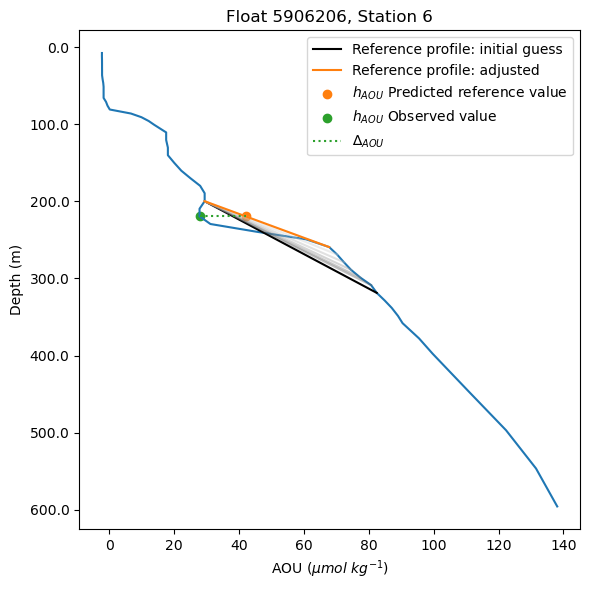

In [20]:
# Derive variables using TEOS-10 and the gsw package in python
fig = plt.figure(figsize=(6,6));
MLD_method = 'dens05'

for floatid in ['5906206']:
    print(floatid)
    db = xr.open_dataset('{}/{}QC.nc'.format(floatspath,floatid))
    
    # Assign Depth as a coordinate, which will allow integration by depth
    db = db.set_coords('Depth')
    
    # Assign relevant parameters to variables
    S = db.Salinity.copy(deep=True)
    T = db.Temperature.copy(deep=True)
    P = db.Pressure.copy(deep=True)
    Z = db.Depth.copy(deep=True)
    depths = Z.copy(deep=True)
    dens = db.Sigma_theta.copy(deep=True)
    dens_QFA = db.Sigma_theta_QFA.copy(deep=True)
    lon2d = np.repeat(db.Lon.values, len(db.N_LEVELS)).reshape(-1, len(db.N_LEVELS)) #reshape lon and lat into 2d arrays to input to absolute salinity function
    lat2d = np.repeat(db.Lat.values, len(db.N_LEVELS)).reshape(-1, len(db.N_LEVELS))
    
    # Check that all profiles have the same dimensions
    assert(np.shape(S) == np.shape(T) == np.shape(P) == np.shape(Z) == np.shape(dens))
    
    # Derive variables using TEOS-10 and the GSW package
    # AOU calculated using oxygen solubility from Garcia and Gordon (1992)
    # Spice calculated according to McDougall and Krzysik (2015)
    # MLDs calculated according to Carvalho et al (2017)
   
    absal = gsw.SA_from_SP(S, P, lon2d, lat2d)
    ctemp = gsw.CT_from_t(absal,T,P)
    ptemp = gsw.pt_from_t(absal,T,P,p_ref=0)
    spice = gsw.spiciness0(absal,ctemp) # Ref pressure 0db: "Calculates spiciness from Absolute Salinity and Conservative Temperature at a pressure of 0 dbar, as described by McDougall and Krzysik (2015)."
    o2sol = gsw.O2sol(absal,ctemp,P,lon2d,lat2d) # "solubility coefficients derived from the data of Benson and Krause (1984), as fitted by Garcia and Gordon (1992, 1993)."
    aou = o2sol - db.Oxygen.data # AOU = expected - observed
    
    # Add as data variables to the dataframe
    db["Spice"] = (['N_PROF', 'N_LEVELS'], spice.data)
    db["Absolute_Salinity"] = (['N_PROF', 'N_LEVELS'], absal.data)
    db["AOU"] = (['N_PROF', 'N_LEVELS'], aou.data)
    db["Conservative_Temp"] = (['N_PROF', 'N_LEVELS'], ctemp.data)
    db["Potential_Temp"] = (['N_PROF', 'N_LEVELS'], ptemp.data)
    
    if floatid in navis_floats:
        ######### DOWNSAMPLE NAVIS FLOATS
        #### Define the N_LEVELS depth indices across the float dataset that correspond to APEX sampling depths 
        #### Store indices in matrix downsampled_i
        #### Mark indices where there is no matchup in downsampled_i_fornan; downsampled data here will be marked nan
        #### N = N_PROF
        #### M = N_LEVELS
        downsampled_i = [] # NxM matrix of N_LEVELS indices for each profile at APEX depths
        downsampled_i_fornan = [ [] for _ in range(len(db.N_PROF))] # Nx0 matrix to hold indices where the Navis float did not sample at the given APEX depth
        
        for i in range(len(apex_schedule)): # For each APEX sampling depth
            d = apex_schedule[i] 
            
            diff_array = np.absolute(db.Depth-d) # NxM Difference array of the full depth dataset vs the target APEX depth
            diff_indices = diff_array.argmin(axis=1) #Nx1 the indices of the nearest depth in each profile (minimum difference)
            
            nearest_depths = db.Depth[:,diff_indices] # Nx1 retrieve the observed depths at those indices in each profile
            nearest_depths_diffs = np.absolute(nearest_depths-d) # Nx1 difference array of those indices versus the target depth (d)
            
            if d<=100:
                no_meas = np.where(nearest_depths_diffs>2.5)[0] # N_PROF Indices where the closest sampled depth was >2.5 m away from target depth (>halfway between 5 m sampling interval)
            elif d>100 and d<=360:
                no_meas = np.where(nearest_depths_diffs>5)[0] # N_PROF Indices where the closest sampled depth was >5 m away from target depth (>halfway between 10 m sampling interval)
            elif d>360 and d<=400:
                no_meas = np.where(nearest_depths_diffs>10)[0] # N_PROF Indices where the closest sampled depth was >10 m away from target depth (>halfway between 20 m sampling interval)
            elif d>400 and d<=1000:
                no_meas = np.where(nearest_depths_diffs>25)[0] # N_PROF Indices where the closest sampled depth was >25 m away from target depth (>halfway between 50 m sampling interval)
            
            for nprof in no_meas:
                downsampled_i_fornan[nprof].extend([59-i]) # Record the N_LEVEL indices for this N_PROF that are NaN
            
            downsampled_i.append(list(diff_indices.values))
            
            
        downsampled_i = np.flip(np.transpose(downsampled_i),axis=1) #  Transpose the matrix from MxN and shallow->deep, into NxM and deep->shallow (standard float data format)
    
        
        #########################
        ###### Use the downsample indices to downsample variable arrays
        
        if len(db.N_PROF)==1 and len(downsampled_i)==1:
            depths_ds = db.Depth[:,downsampled_i[0]]
            P_ds = db.Pressure[:,downsampled_i[0]]
            dens_ds = db.Sigma_theta[:,downsampled_i[0]]
            dens_QFA_ds = db.Sigma_theta_QFA[:,downsampled_i[0]]
            T_ds = db.Conservative_Temp[:,downsampled_i[0]]
            S_ds = db.Absolute_Salinity[:,downsampled_i[0]]
            spice_ds = db.Spice[:,downsampled_i[0]]
            aou_ds = db.AOU[:,downsampled_i[0]]
            chl_ds = db.Chl_a[:,downsampled_i[0]]
            bbp_ds = db.b_bp700[:,downsampled_i[0]]
            poc_ds = db.POC[:,downsampled_i[0]]
            
        elif len(db.N_PROF) > 1:
            # Initialize downsampled arrays for each variable by indexing the first profile at just the APEX depths
            depths_ds = db.Depth[0,downsampled_i[0]]
            P_ds = db.Pressure[0,downsampled_i[0]]
            dens_ds = db.Sigma_theta[0,downsampled_i[0]]
            dens_QFA_ds = db.Sigma_theta_QFA[0,downsampled_i[0]]
            T_ds = db.Conservative_Temp[0,downsampled_i[0]]
            S_ds = db.Absolute_Salinity[0,downsampled_i[0]]
            spice_ds = db.Spice[0,downsampled_i[0]]
            aou_ds = db.AOU[0,downsampled_i[0]]
            chl_ds = db.Chl_a[0,downsampled_i[0]]
            bbp_ds = db.b_bp700[0,downsampled_i[0]]
            poc_ds = db.POC[0,downsampled_i[0]]
            
            # Replace unsampled depths with NAN (at the N_LEVELS indices recorded earlier)
            depths_ds[downsampled_i_fornan[0]] = np.nan
            P_ds[downsampled_i_fornan[0]] = np.nan
            dens_ds[downsampled_i_fornan[0]] = np.nan
            dens_QFA_ds[downsampled_i_fornan[0]] = np.nan
            T_ds[downsampled_i_fornan[0]] = np.nan
            S_ds[downsampled_i_fornan[0]] = np.nan
            spice_ds[downsampled_i_fornan[0]] = np.nan
            aou_ds[downsampled_i_fornan[0]] = np.nan
            chl_ds[downsampled_i_fornan[0]] = np.nan
            bbp_ds[downsampled_i_fornan[0]] = np.nan
            poc_ds[downsampled_i_fornan[0]] = np.nan
            
            # Downsample each variable by indexing each profile, substituting NANs, and then concatenating with the downsampled data array
            for i in range(1,len(downsampled_i)):
                depths_ds_prof = db.Depth[i,downsampled_i[i]]
                P_ds_prof = db.Pressure[i,downsampled_i[i]]
                dens_ds_prof = db.Sigma_theta[i,downsampled_i[i]]
                dens_QFA_ds_prof = db.Sigma_theta_QFA[i,downsampled_i[i]]
                T_ds_prof = db.Conservative_Temp[i,downsampled_i[i]]
                S_ds_prof = db.Absolute_Salinity[i,downsampled_i[i]]
                spice_ds_prof = db.Spice[i,downsampled_i[i]]
                aou_ds_prof = db.AOU[i,downsampled_i[i]]
                chl_ds_prof = db.Chl_a[i,downsampled_i[i]]
                bbp_ds_prof = db.b_bp700[i,downsampled_i[i]]
                poc_ds_prof = db.POC[i,downsampled_i[i]]
                    
                depths_ds_prof[downsampled_i_fornan[i]] = np.nan
                P_ds_prof[downsampled_i_fornan[i]] = np.nan
                dens_ds_prof[downsampled_i_fornan[i]] = np.nan
                dens_QFA_ds_prof[downsampled_i_fornan[i]] = np.nan
                T_ds_prof[downsampled_i_fornan[i]] = np.nan
                S_ds_prof[downsampled_i_fornan[i]] = np.nan
                spice_ds_prof[downsampled_i_fornan[i]] = np.nan
                aou_ds_prof[downsampled_i_fornan[i]] = np.nan
                chl_ds_prof[downsampled_i_fornan[i]] = np.nan
                bbp_ds_prof[downsampled_i_fornan[i]] = np.nan
                poc_ds_prof[downsampled_i_fornan[i]] = np.nan
                    
                depths_ds = xr.concat([depths_ds, depths_ds_prof], dim="N_PROF")
                P_ds = xr.concat([P_ds, P_ds_prof], dim="N_PROF")
                dens_ds = xr.concat([dens_ds, dens_ds_prof], dim="N_PROF")
                dens_QFA_ds = xr.concat([dens_QFA_ds, dens_QFA_ds_prof], dim="N_PROF")
                T_ds = xr.concat([T_ds, T_ds_prof], dim="N_PROF")
                S_ds = xr.concat([S_ds, S_ds_prof], dim="N_PROF")
                spice_ds = xr.concat([spice_ds, spice_ds_prof], dim="N_PROF")
                aou_ds = xr.concat([aou_ds, aou_ds_prof], dim="N_PROF")
                chl_ds = xr.concat([chl_ds, chl_ds_prof], dim="N_PROF")
                bbp_ds = xr.concat([bbp_ds, bbp_ds_prof], dim="N_PROF")
                poc_ds = xr.concat([poc_ds, poc_ds_prof], dim="N_PROF")
        
        depths = depths_ds.copy(deep=True) # For code reuseability with APEX floats, now with the truncated shape of the downsampled arrays
        dens = dens_ds.copy(deep=True)
    #########################
    #########################
    
    if MLD_method == 'maxn2':
        if floatid in apex_floats:
            MLD, indicesMLD, maxn2 = profile2mld_n2(dens, P, Z, absal, ctemp, num_rows_ignore=0)
        elif floatid in navis_floats:
            MLD, indicesMLD, maxn2 = profile2mld_n2(dens_ds, P_ds, depths_ds, S_ds, T_ds, num_rows_ignore=0)
    
    elif MLD_method == 'dens05':
        if floatid in apex_floats:
            MLD, indicesMLD = mld05(dens,dens_QFA)
            MLD_maxn2, indicesMLD_maxn2, maxn2 = profile2mld_n2(dens, P, Z, absal, ctemp, num_rows_ignore=0)
        elif floatid in navis_floats:
            MLD, indicesMLD = mld05(dens_ds,dens_QFA_ds)
            MLD_navis, indicesMLD_navis = mld05(db.Sigma_theta,db.Sigma_theta_QFA)
            MLD_maxn2, indicesMLD_maxn2, maxn2 = profile2mld_n2(dens_ds, P_ds, depths_ds, S_ds, T_ds, num_rows_ignore=0)
    
    # Add as data variables to the dataframe
    db["Mixed_Layer_Depth"] = (['N_PROF'], MLD)
    db['Max_N2'] = ('N_PROF',maxn2)
    
    #########################
    # Calculate 3-bin rolling medians for variables of interest. Don't drop nans.
    # For Navis floats, use the downsampled data
    
    if floatid in apex_floats:
        
        T_bin3 = db.Conservative_Temp.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        S_bin3 = db.Absolute_Salinity.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        spicebin3 = db.Spice.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        aou_bin3 = db.AOU.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        aou_bin20 = db.AOU.rolling(N_LEVELS=20,center=True,min_periods=10).median()
        bbp_bin3 = db.b_bp700.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        chl_bin3 = db.Chl_a.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        poc_bin3 = db.POC.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        
        bbp_despiked = np.nan
        bbp_spikes = np.nan
        chl_despiked = np.nan
        chl_spikes = np.nan
        poc_despiked = np.nan
        poc_spikes = np.nan
    
    elif floatid in navis_floats: # Use the downsampled data for rolling medians for Navis data
        
        T_bin3 = T_ds.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        S_bin3 = S_ds.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        spicebin3 = spice_ds.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        aou_bin3 = aou_ds.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        aou_bin20 = aou_ds.rolling(N_LEVELS=20,center=True,min_periods=10).median()
        bbp_bin3 = bbp_ds.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        chl_bin3 = chl_ds.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        poc_bin3 = poc_ds.rolling(N_LEVELS=3,center=True,min_periods=2).median()

    # Calculate the chl/bbp ratio by dividing the 3-bin smoothed profiles
    chl_bbp_ratio3 = chl_bin3/bbp_bin3
    
    ########### Create empty variables for reference profiles of variables of interest. Use these just to input the points used to calculate the reference profile (above and below an anomaly).
    ####### By integrating through these points (straight line), I will calculate the "background" integrated quantity of a given variable
    # First duplicate the original arrays
    bbp_refprofs = bbp_bin3.copy(deep=True) 
    chl_refprofs = chl_bin3.copy(deep=True)
    poc_refprofs = poc_bin3.copy(deep=True)
    chl_bbp_refprofs = chl_bbp_ratio3.copy(deep=True)
    
    # Then make them all NaN
    bbp_refprofs[:,:], chl_refprofs[:,:], poc_refprofs[:,:], chl_bbp_refprofs[:,:] = np.nan,np.nan,np.nan,np.nan
    
    ###############
    
    
    for i in [5]: # For each profile:   
        
        prof_anoms = [] # Record the values of AOU anomalies in this vertical profile, as well as their depth indices [[magnitude,index]]
        
        if np.any(np.where(depths[i]<600)) and S[i].dropna(dim='N_LEVELS')[-1]<35 and -30>db.Lat[i]>-65 and ~np.isnan(db.Mixed_Layer_Depth[i]): # If the profile reached a depth shallower than 600 m, and has a surface Salinity <35 (to discard tropical water incursions), is between -30 and -65 latitude, and had a valid MLD calculation (not faulty CTD)
            
            lons_all.append(db.Lon[i].item()) # Record the profile as considered (coordinates)
            lats_all.append(db.Lat[i].item())
            
            index600 = np.where(depths[i]<600)[0][0] # Get the first index of profie i where depth < 600 m (depth array = [deep:shallow])
            index1000 = np.where(depths[i]<1000)[0][0] # Get the first index of profie i where depth < 1000 m (depth array = [deep:shallow]) 
            
            if np.any(np.where(depths[i]>100)): # Get the last index where depth > 100 m
                index100 = np.where(depths[i]>100)[0][-1]
            else:
                index100 = np.nan
                
            upperbound = int(np.nanmin([index100,indicesMLD[i]])) # Stop either 100 m or the MLD, whichever comes first
            

            
            if index600 < indicesMLD[i]: # If the mixed layer is shallower than 600 m (otherwise ignore the profile)
                
                # Find local maxima in 3-bin smoothed profiles using scipy's find_peaks method: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html
                aou_peaks = find_peaks(-aou_bin3[i])[0] # Returns the indices of the peaks. Negative input in order to detect minima
                spice_peaks = find_peaks(-spicebin3[i])[0]
                #poc_peaks = find_peaks(poc_bin3[i])[0] # Detect positive POC peaks
                
                if np.any(aou_peaks) and np.any(spice_peaks): # If there are peaks in both AOU and spice profiles
                    
                    # Check that there are peaks between index600 and upperbound+1
                    aou_peaks = aou_peaks[np.where((aou_peaks<upperbound) & (aou_peaks>index600))[0]] # Filter peak indices -- only those indices in the given depth range
                    spice_peaks = spice_peaks[np.where((spice_peaks<upperbound) & (spice_peaks>index600))[0]]
                    
                    if np.any(aou_peaks) and np.any(spice_peaks): # If both AOU and spice have peaks in the given depth range
                    
                        for x in aou_peaks: # Pairwise assessment of each AOU and spice peak pair
                            for y in spice_peaks: # Note: define AOU and spice at their *respective* peak depths (may be slightly offset). MAY REVISIT LATER?
                                
                                if (abs(aou_bin3[i].Depth[x] - spicebin3[i].Depth[y]) < 30): # The peaks must be be within 30 m of each other (for most floats, this is 3 sampling intervals)
                                    
                                    # Record the depths and values of the AOU and spice peaks
                                    aou_peakdepth = aou_bin3[i,x].Depth.item()
                                    spice_peakdepth = spicebin3[i,y].Depth.item()
                                    
                                    aou_peakval  = aou_bin3[i,x].item()
                                    spice_peakval = spicebin3[i,y].item()
                                    
                                    plt.plot(aou_bin3[i,index600:],np.negative(aou_bin3[i,index600:].Depth.values))
                                    #plt.plot(aou_bin20[i,index600:],np.negative(aou_bin20[i,index600:].Depth.values),linestyle='dotted')
                                    
                                    ####### Define the reference profiles (without subduction anomalies)
                                    
                                    ### 1) Start by identifying the points 100 m above and below each peak
                                    aou_reference_lower_i = np.where(depths[i]<aou_peakdepth+100)[0][0] # Index of the point 100 m below the AOU peak (less than/equal to)
                                    aou_reference_upper_i = np.where(depths[i]>aou_peakdepth-100)[0][-1] # Index of the point 100 m above the AOU peak (less than/equal to)
                                    
                                    spice_reference_lower_i = np.where(depths[i]<spice_peakdepth+100)[0][0] #  Index of the point 100 m below the spice peak (less than/equal to)
                                    spice_reference_upper_i = np.where(depths[i]>spice_peakdepth-100)[0][-1] ## Index of the point 100 m above the spice peak (less than/equal to)
                                    
                                    ### 2) For each depth interval (100 m above, 100m below), identify the maximum (most positive) AOU or spice value
                                    aou_upperbound_maxval = aou_bin3[i, x:aou_reference_upper_i+1].max() # Value of the maximum AOU value in the (peak+100m) depth range (may have duplicates)
                                    aou_upperbound_max_i = np.where(aou_bin3[i, x:aou_reference_upper_i+1]==aou_upperbound_maxval)[0][0] # Find the first index in this range (deepest depth) where this maximum value occurs
                                    aou_upperbound_max = aou_bin3[i, x:aou_reference_upper_i+1][aou_upperbound_max_i].item() # The maximum value and its depth
                                    aou_upperbound_max_depth = aou_bin3[i, x:aou_reference_upper_i+1][aou_upperbound_max_i].Depth.item() # The maximum value and its depth
                                    
                                    aou_lowerbound_maxval = aou_bin3[i,aou_reference_lower_i:x].max() # Value of the maximum AOU value in the (peak+100m) depth range (may have duplicates)
                                    aou_lowerbound_max_i = np.where(aou_bin3[i,aou_reference_lower_i:x]==aou_lowerbound_maxval)[0][-1] # Find the last index in this range (shallowest depth) where this maximum value occurs
                                    aou_lowerbound_max = aou_bin3[i,aou_reference_lower_i:x][aou_lowerbound_max_i].item() # The maximum value and its depth
                                    aou_lowerbound_max_depth = aou_bin3[i,aou_reference_lower_i:x][aou_lowerbound_max_i].Depth.item() # The maximum value and its depth
                                    
                                    spice_upperbound_maxval = spicebin3[i, y:spice_reference_upper_i+1].max() # Value of the maximum spice value in the (peak+100m) depth range (may have duplicates)
                                    spice_upperbound_max_i = np.where(spicebin3[i, y:spice_reference_upper_i+1]==spice_upperbound_maxval)[0][0] # Find the first index in this range (deepest depth) where this maximum value occurs
                                    spice_upperbound_max = spicebin3[i, y:spice_reference_upper_i+1][spice_upperbound_max_i].item() # The maximum value and its depth
                                    spice_upperbound_max_depth = spicebin3[i, y:spice_reference_upper_i+1][spice_upperbound_max_i].Depth.item() # The maximum value and its depth
                                    
                                    spice_lowerbound_maxval = spicebin3[i,spice_reference_lower_i:y].max() # Value of the maximum spice value in the (peak+100m) depth range (may have duplicates)
                                    spice_lowerbound_max_i = np.where(spicebin3[i,spice_reference_lower_i:y]==spice_lowerbound_maxval)[0][-1] # Find the last index in this range (shallowest depth) where this maximum value occurs
                                    spice_lowerbound_max = spicebin3[i,spice_reference_lower_i:y][spice_lowerbound_max_i].item() # The maximum value and its depth
                                    spice_lowerbound_max_depth = spicebin3[i,spice_reference_lower_i:y][spice_lowerbound_max_i].Depth.item() # The maximum value and its depth
                                    
                                    ### 3) Construct the reference profile: draw a straight line between the maximum values above and below the peak
                                    aou_reference_x = np.array([aou_upperbound_max_depth, aou_lowerbound_max_depth]).reshape((-1, 1)) # Independent variable: depth
                                    aou_reference_y = np.array([aou_upperbound_max, aou_lowerbound_max]) # Dependent variable: predicted AOU value
                                    
                                    aou_model = LinearRegression().fit(aou_reference_x, aou_reference_y) # Construct the regression model 
                                    
                                    spice_reference_x = np.array([spice_upperbound_max_depth, spice_lowerbound_max_depth]).reshape((-1, 1)) # Independent variable: depth
                                    spice_reference_y = np.array([spice_upperbound_max, spice_lowerbound_max]) # Dependent variable: predicted spice value
                                    
                                    spice_model = LinearRegression().fit(spice_reference_x, spice_reference_y) # Construct the regression model 
                                    

                                    ### 3b) Iteratively adjust the reference profile so that it doesn't intersect the observed profile
                                    # Construct the reference profile at all depths
                                    aou_refprof_iter_lower_i = np.where(aou_bin3[i].Depth==aou_lowerbound_max_depth)[0][0]
                                    aou_refprof_iter_upper_i = np.where(aou_bin3[i].Depth==aou_upperbound_max_depth)[0][0]
                                    aou_refprof_iter_depths = aou_bin3[i,aou_refprof_iter_lower_i:aou_refprof_iter_upper_i+1].Depth.values
                                    aou_refprof_iter_depths_input = aou_refprof_iter_depths.reshape((-1,1))
                                    aou_refprof_iter_vals = aou_model.predict(aou_refprof_iter_depths_input)
                                    aou_refprof_iter_observed = aou_bin3[i,aou_refprof_iter_lower_i:aou_refprof_iter_upper_i+1].values
                                
                                    aou_refprof_iter_peakindex = np.where(aou_refprof_iter_depths==aou_peakdepth)[0][0] # The index within the reference profile of the peak
                                    aou_refprof_iter_diff = aou_refprof_iter_vals - aou_refprof_iter_observed
                                    
                                    plt.plot(aou_refprof_iter_vals,np.negative(aou_refprof_iter_depths),c='black',label='Reference profile: initial guess')
                                    
                                    opt_iter = 3
                                    colors = plt.cm.Greys_r(np.linspace(0,1,11))
                                    
                                    if np.any(aou_refprof_iter_diff[0:aou_refprof_iter_peakindex] < -1e-13): # If the bottom of the observed profile goes above (more + than) the reference profile
                                        intersectLower = True
                                        
                                        while (aou_refprof_iter_lower_i < x-1) and intersectLower==True: 
                                            if np.isnan(aou_bin3[i,aou_refprof_iter_lower_i+1]): #If the next index is an nan, stop the optimization routine
                                                break
                                            #print(aou_refprof_iter_diff)
                                            aou_refprof_iter_lower_i +=1 # Iterate the lowerbound one index shallower at a time
                                            
                                            aou_refprof_iter_depths = aou_bin3[i,aou_refprof_iter_lower_i:aou_refprof_iter_upper_i+1].Depth.values
                                            aou_refprof_iter_depths_input = aou_refprof_iter_depths.reshape((-1,1))
                                            aou_refprof_iter_observed = aou_bin3[i,aou_refprof_iter_lower_i:aou_refprof_iter_upper_i+1].values
                                            aou_refprof_iter_peakindex = np.where(aou_refprof_iter_depths==aou_peakdepth)[0][0] # The index within the reference profile of the peak
                                            
                                            # Reconstruct the regression reference model
                                            aou_reference_x = np.array([aou_refprof_iter_depths[-1], aou_refprof_iter_depths[0]]).reshape((-1, 1))
                                            aou_reference_y = np.array([aou_refprof_iter_observed[-1], aou_refprof_iter_observed[0]])
                                            aou_model = LinearRegression().fit(aou_reference_x, aou_reference_y)
                                            
                                            # Use the model to predict the reference profile again
                                            aou_refprof_iter_vals = aou_model.predict(aou_refprof_iter_depths_input)
                                            aou_refprof_iter_diff = aou_refprof_iter_vals - aou_refprof_iter_observed
                                            
                                            if np.any(aou_refprof_iter_diff[0:aou_refprof_iter_peakindex] < -1e-13) == False:
                                                intersectLower = False
                                            plt.plot(aou_refprof_iter_vals,np.negative(aou_refprof_iter_depths),c=colors[opt_iter],alpha=0.4)
                                            opt_iter+=1
                                        
                                    if np.any(aou_refprof_iter_diff[aou_refprof_iter_peakindex:] < -1e-13): # If the top of the observed profile goes above (more + than) the reference profile
                                        intersectUpper = True
                                        
                                        while (aou_refprof_iter_upper_i > x+1) and intersectUpper==True:
                                            if np.isnan(aou_bin3[i,aou_refprof_iter_upper_i-1]):
                                                break
                                                
                                            aou_refprof_iter_upper_i -=1 # Iterate the lowerbound one index shallower at a time
                                            
                                            aou_refprof_iter_depths = aou_bin3[i,aou_refprof_iter_lower_i:aou_refprof_iter_upper_i+1].Depth.values
                                            aou_refprof_iter_depths_input = aou_refprof_iter_depths.reshape((-1,1))
                                            aou_refprof_iter_observed = aou_bin3[i,aou_refprof_iter_lower_i:aou_refprof_iter_upper_i+1].values
                                            aou_refprof_iter_peakindex = np.where(aou_refprof_iter_depths==aou_peakdepth)[0][0] # The index within the reference profile of the peak
                                            
                                            # Reconstruct the regression reference model
                                            aou_reference_x = np.array([aou_refprof_iter_depths[-1], aou_refprof_iter_depths[0]]).reshape((-1, 1))
                                            aou_reference_y = np.array([aou_refprof_iter_observed[-1], aou_refprof_iter_observed[0]])
                                            aou_model = LinearRegression().fit(aou_reference_x, aou_reference_y)
                                            
                                            # Use the model to predict the reference profile again
                                            aou_refprof_iter_vals = aou_model.predict(aou_refprof_iter_depths_input)
                                            aou_refprof_iter_diff = aou_refprof_iter_vals - aou_refprof_iter_observed
                                            
                                            if np.any(aou_refprof_iter_diff[aou_refprof_iter_peakindex:] < -1e-13) == False:
                                                intersectUpper = False
                                        plt.plot(aou_refprof_iter_vals,np.negative(aou_refprof_iter_depths),alpha=0.5)
                                    
                                    plt.plot(aou_refprof_iter_vals,np.negative(aou_refprof_iter_depths),c='tab:Orange',label='Reference profile: adjusted')    
                                    ### 3c) Repeat for spice profile. Iteratively adjust the reference profile so that it doesn't intersect the observed profile
                                    # Construct the reference profile at all depths
                                    spice_refprof_iter_lower_i = np.where(spicebin3[i].Depth==spice_lowerbound_max_depth)[0][0]
                                    spice_refprof_iter_upper_i = np.where(spicebin3[i].Depth==spice_upperbound_max_depth)[0][0]
                                    spice_refprof_iter_depths = spicebin3[i,spice_refprof_iter_lower_i:spice_refprof_iter_upper_i+1].Depth.values
                                    spice_refprof_iter_depths_input = spice_refprof_iter_depths.reshape((-1,1))
                                    spice_refprof_iter_vals = spice_model.predict(spice_refprof_iter_depths_input)
                                    spice_refprof_iter_observed = spicebin3[i,spice_refprof_iter_lower_i:spice_refprof_iter_upper_i+1].values
                                    
                                    spice_refprof_iter_peakindex = np.where(spice_refprof_iter_depths==spice_peakdepth)[0][0] # The index within the reference profile of the peak
                                    spice_refprof_iter_diff = spice_refprof_iter_vals - spice_refprof_iter_observed
                                    
                                    if np.any(spice_refprof_iter_diff[0:spice_refprof_iter_peakindex] < 0): # If the bottom of the observed profile goes above (more + than) the reference profile
                                        intersectLower = True
                                        
                                        while (spice_refprof_iter_lower_i < y-1) and intersectLower==True:
                                            if np.isnan(spicebin3[i,spice_refprof_iter_lower_i+1]):
                                                break
                                                
                                            spice_refprof_iter_lower_i +=1 # Iterate the lowerbound one index shallower at a time
                                            
                                            spice_refprof_iter_depths = spicebin3[i,spice_refprof_iter_lower_i:spice_refprof_iter_upper_i+1].Depth.values
                                            spice_refprof_iter_depths_input = spice_refprof_iter_depths.reshape((-1,1))
                                            spice_refprof_iter_observed = spicebin3[i,spice_refprof_iter_lower_i:spice_refprof_iter_upper_i+1].values
                                            spice_refprof_iter_peakindex = np.where(spice_refprof_iter_depths==spice_peakdepth)[0][0] # The index within the reference profile of the peak
                                            
                                            spice_reference_x = np.array([spice_refprof_iter_depths[-1], spice_refprof_iter_depths[0]]).reshape((-1, 1))
                                            spice_reference_y = np.array([spice_refprof_iter_observed[-1], spice_refprof_iter_observed[0]])
                                            spice_model = LinearRegression().fit(spice_reference_x, spice_reference_y)
                                            
                                            # Use the model to predict the reference profile again
                                            spice_refprof_iter_vals = spice_model.predict(spice_refprof_iter_depths_input)
                                            spice_refprof_iter_diff = spice_refprof_iter_vals - spice_refprof_iter_observed
                                            
                                            if np.any(spice_refprof_iter_diff[0:spice_refprof_iter_peakindex] < 0) == False:
                                                intersectLower = False
                                    
                                    if np.any(spice_refprof_iter_diff[spice_refprof_iter_peakindex:] < 0): # If the top of the observed profile goes above (more + than) the reference profile
                                        intersectUpper = True
                                        
                                        while (spice_refprof_iter_upper_i > y+1) and intersectUpper==True:
                                            if np.isnan(spicebin3[i,spice_refprof_iter_upper_i-1]):
                                                break
                                                
                                            spice_refprof_iter_upper_i -=1 # Iterate the lowerbound one index shallower at a time
                                            
                                            spice_refprof_iter_depths = spicebin3[i,spice_refprof_iter_lower_i:spice_refprof_iter_upper_i+1].Depth.values
                                            spice_refprof_iter_depths_input = spice_refprof_iter_depths.reshape((-1,1))
                                            spice_refprof_iter_observed = spicebin3[i,spice_refprof_iter_lower_i:spice_refprof_iter_upper_i+1].values
                                            spice_refprof_iter_peakindex = np.where(spice_refprof_iter_depths==spice_peakdepth)[0][0] # The index within the reference profile of the peak
                                                
                                            spice_reference_x = np.array([spice_refprof_iter_depths[-1], spice_refprof_iter_depths[0]]).reshape((-1, 1))
                                            spice_reference_y = np.array([spice_refprof_iter_observed[-1], spice_refprof_iter_observed[0]])
                                            spice_model = LinearRegression().fit(spice_reference_x, spice_reference_y)
                                            
                                            # Use the model to predict the reference profile again
                                            spice_refprof_iter_vals = spice_model.predict(spice_refprof_iter_depths_input)
                                            spice_refprof_iter_diff = spice_refprof_iter_vals - spice_refprof_iter_observed
                                            
                                            if np.any(spice_refprof_iter_diff[spice_refprof_iter_peakindex:] < 0) == False:
                                                intersectUpper = False
                                    
                                    
                                
                                    ### 4) Determine the anomaly size at the peak
                                    aou_refval = aou_model.predict([[aou_peakdepth]]).item()
                                    spice_refval = spice_model.predict([[spice_peakdepth]]).item()
                                    
                                    ######## Determine if it's a true anomaly. Must meet 4 conditions to be an anomaly
                                    # Depth of the AOU and spice peaks must be within 30 m of each other (for most floats, this is 3 sampling intervals)
                                    # The AOU anomaly (diff between 3-bin and 20-bin medians) must be < -8
                                    # The spice anomaly (diff between 3-bin and 20-bin medians) must be < -0.05
                                    # Must be at least 100 m below the MLD
                                    
                                    if np.less(aou_peakval - aou_refval, -8) and np.less(spice_peakval - spice_refval, -0.05) and aou_peakdepth > (MLD[i]+100):
                                        # Record this profile's anomalies: [AOU N_LEVELs index, AOU magnitude, spice N_LEVELS index, spice magnitude, AOU reference values (upper/lower), spice reference values (upper/lower), predicted AOU reference, predicted spice reference]
                                        #prof_anoms.append([x, aou_peakval - aou_refval, y, spice_peakval - spice_refval, aou_reference_x.reshape(1,-1)[0], aou_reference_y, spice_reference_x.reshape(1,-1)[0], spice_reference_y, aou_refval, spice_refval]) 
                                        prof_anoms.append([x, aou_peakval, aou_peakval - aou_refval, y, spice_peakval, spice_peakval - spice_refval, aou_refprof_iter_depths[-1], aou_refprof_iter_upper_i, aou_refprof_iter_depths[0], aou_refprof_iter_lower_i, aou_refprof_iter_observed[-1], aou_refprof_iter_observed[0], spice_refprof_iter_depths[-1], spice_refprof_iter_depths[0], spice_refprof_iter_observed[-1], spice_refprof_iter_observed[0], aou_refval, spice_refval]) 
                                        plt.scatter(aou_refval,-aou_peakdepth,c='tab:Orange',label='$h_{AOU}$ Predicted reference value')
                                        plt.scatter(aou_peakval,-aou_peakdepth,c='tab:Green',label='$h_{AOU}$ Observed value')
                                        
                                        
ax=plt.gca()                                        

plt.ylabel('Depth (m)')
@mticker.FuncFormatter
def major_formatter(x, pos):
    label = str(-x) if x < 0 else str(x)
    return label
ax=plt.gca()
plt.plot([aou_peakval,aou_refval],[-aou_peakdepth,-aou_peakdepth],c='tab:Green',linestyle='dotted',label='$∆_{AOU}$')

ax.yaxis.set_major_formatter(major_formatter)
plt.xlabel('AOU ($µmol$ $kg^{-1}$)')
plt.title('Float 5906206, Station 6')
#plt.ylim(-400,0)
plt.legend()

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
fig.savefig('figures/figureS1_anomaly-optimization.png',bbox_inches='tight')

## FSLE field for example anomaly

In [24]:
fsle_ex = xr.open_dataset('fsles/_fsles_snapshot_float_5904673_50.nc')

In [25]:
# https://mom6-analysiscookbook.readthedocs.io/en/latest/notebooks/Plotting.html
anomlon = anoms[anoms['floatstation']=='5904673_50'].Lon
anomlat = anoms[anoms['floatstation']=='5904673_50'].Lat

beforelon = profsummaries[profsummaries['floatstation']=='5904673_49'].Lon
beforelat = profsummaries[profsummaries['floatstation']=='5904673_49'].Lat

afterlon = profsummaries[profsummaries['floatstation']=='5904673_51'].Lon
afterlat = profsummaries[profsummaries['floatstation']=='5904673_51'].Lat

offset = 4
extent = [anomlon-offset, anomlon+offset, anomlat-offset, anomlat+offset]




fig = plt.figure(figsize=(9,9))
ax = plt.axes(projection=ccrs.PlateCarree())
gls = ax.gridlines(draw_labels=True)
gls.top_labels=False   # suppress top labels
gls.right_labels=False # suppress right labels
gls.xlocator = mticker.FixedLocator([-150,-148,-146,-144])
gls.xformatter = LONGITUDE_FORMATTER
gls.xlabel_style = {'size': 18}
gls.ylocator = mticker.FixedLocator([-52,-54,-56,-58])
gls.yformatter = LATITUDE_FORMATTER
gls.ylabel_style = {'size': 18}
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_extent(extent)
data_crs = ccrs.PlateCarree()
    
timeslice = fsle_ex.sel(time = fsle_ex.time[10]).fsle_max
#fsleplot = timeslice.plot(ax=ax,transform = data_crs,cmap = 'binary_r',cbar_kwargs={'shrink':0.8,'label':'FSLE ($days^{-1}$)'},vmin=-1.0, add_labels=False)
fsleplot = timeslice.plot(ax=ax,transform = data_crs,cmap = 'binary_r',vmin=-1.0, add_labels=False,add_colorbar=False)
cb = plt.colorbar(fsleplot, ticks=[-1,-.8,-.6,-.4,-.2,0], shrink=0.8)
cb.set_label(label='FSLE ($days^{-1}$)',size=22)
cb.ax.tick_params(labelsize=18)

#ax.cbar.ax.tick_params(labelsize=12)
ax.scatter(anomlon, anomlat, c = 'red', transform=data_crs, s=30)
rectangle = plt.Rectangle((anomlon-0.5,anomlat-0.5), 1, 1, fc='red',alpha=0.2,transform=data_crs)
ax.add_patch(rectangle)
ax.tick_params(axis='both', which='major', labelsize=10)
#ax.tick_params(axis='both', which='minor', labelsize=8)
ax.set_title('')
#plt.show()
fig.savefig('figures/fsle_field_example_anomaly.png',bbox_inches='tight')
plt.close()
#

## Figure 1: Example anomaly

<Figure size 640x480 with 0 Axes>

/Users/Michael/miniconda3/envs/so_argo/lib/python3.8/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


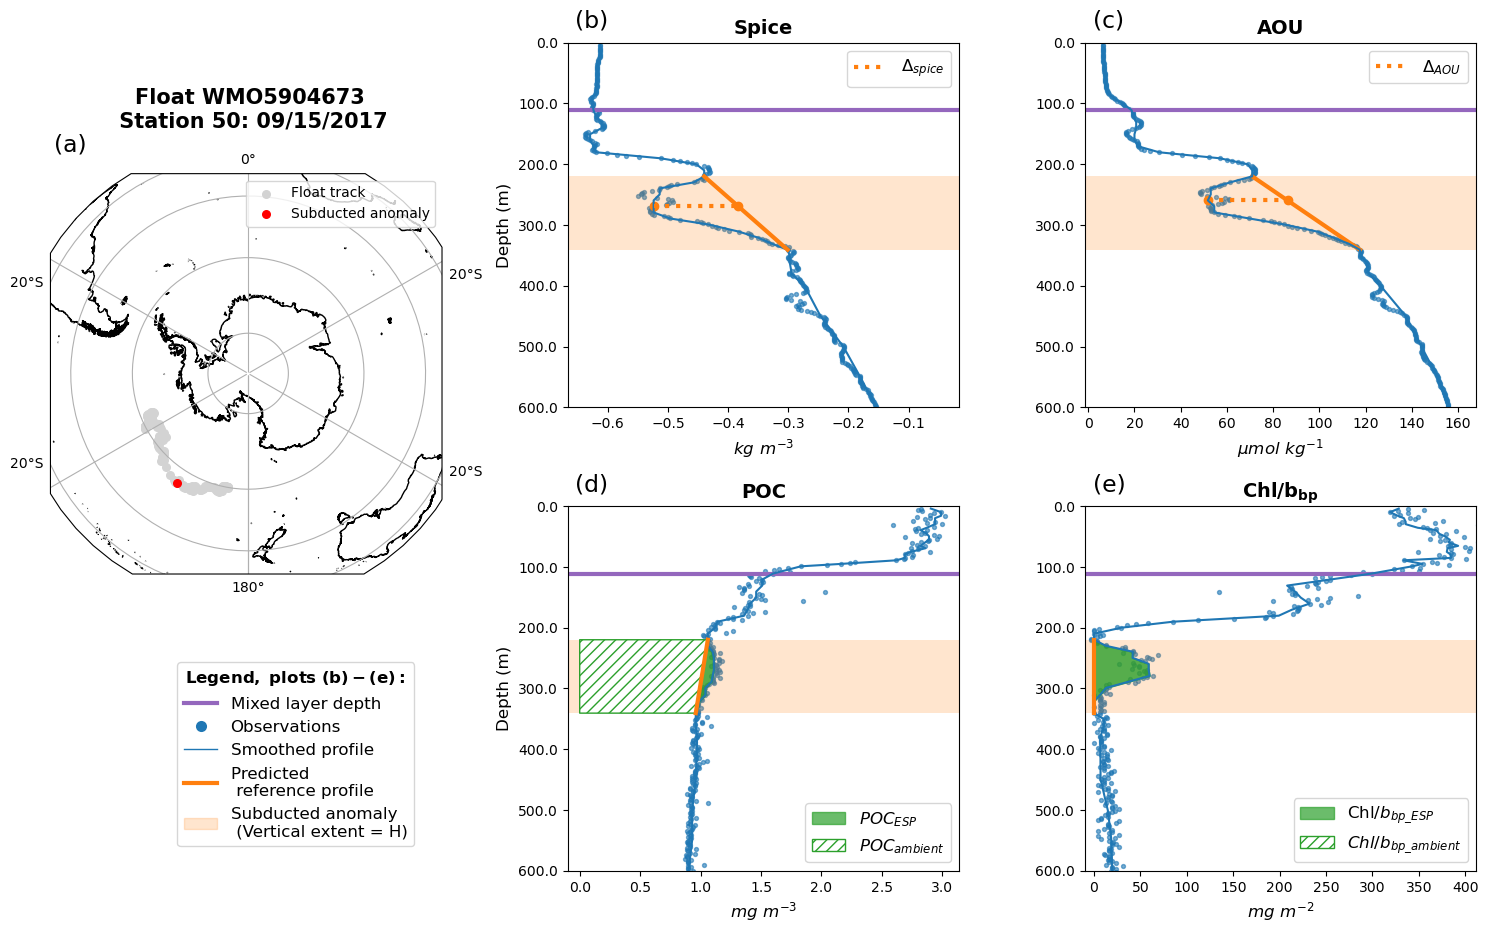

In [26]:
CalcAndPlot(floatid='5904673',profile=49)

In [76]:
db, spicebin3, sigmatheta_bin3, aou_bin3, poc_bin3, chl_bin3 ,bbp_bin3,chl_bbp_ratio3 = calculateFloatVars('5904673',reorder=False)
profile=49
floatid='5904673'
meso=True
observations=True
highlight=True

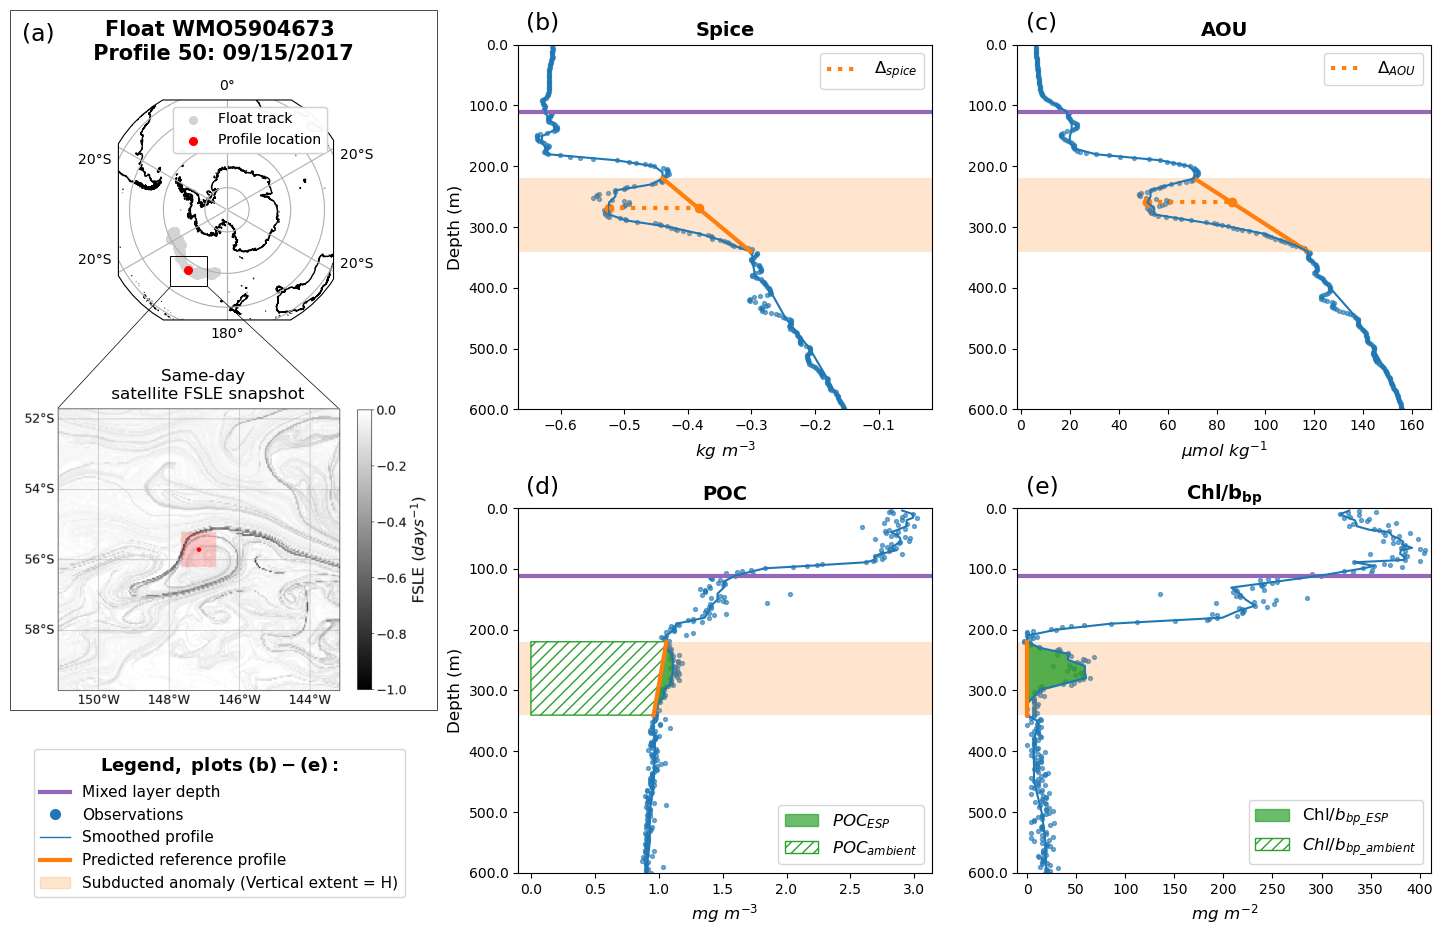

In [79]:
image = Image.open('figures/fsle_field_example_anomaly.png')

@mticker.FuncFormatter
def major_formatter(x, pos):
    label = str(-x) if x < 0 else str(x)
    return label



# Make the figure
fig = plt.figure(figsize=(15,10));
gs = fig.add_gridspec(ncols=3, nrows=2);

station = db.Station[profile].item()

######################### Map 
anoms_db = anoms[(anoms['Float']==floatid)]
proj = ccrs.Orthographic(central_longitude=0, central_latitude = -90)
data_crs = ccrs.PlateCarree()

gs00 = matplotlib.gridspec.GridSpecFromSubplotSpec(150,1, subplot_spec=gs[0:3,0])
ax1 = fig.add_subplot(gs00[10:50,0],projection=proj);
#ax1 = fig.add_subplot(gs[0:2, 0],projection=proj);
ax1.coastlines(resolution='10m')
ax1.gridlines(draw_labels=True)

profsummaries_db = profsummaries[(profsummaries['Float']==floatid)]
ax1.scatter(profsummaries_db.Lon, profsummaries_db.Lat, c = 'lightgray', transform=data_crs, s=30, label='Float track')
ax1.scatter(anoms_db[(anoms_db['Station']==profile+1)].Lon, anoms_db[(anoms_db['Station']==profile+1)].Lat,c='red', transform=data_crs, s=30,label='Profile location')
ax1.set_extent([-180, 180, -90, -30], crs=data_crs)

handles1, labels1 = ax1.get_legend_handles_labels()
maplegend = ax1.legend(handles=handles1)
ax1.add_artist(maplegend)


#prop=matplotlib.font_manager.FontProperties(fname='/System/Library/Fonts/Supplemental/Arial Bold.ttf'))

########################### Inset FSLE field
ax1inset = fig.add_subplot(gs00[35:200,0]);
ax1inset.spines['top'].set_visible(False)
ax1inset.spines['right'].set_visible(False)
ax1inset.spines['bottom'].set_visible(False)
ax1inset.spines['left'].set_visible(False)
ax1inset.set_xticks([])
ax1inset.set_yticks([])
ax1inset.set_xticklabels([])
ax1inset.set_yticklabels([])
ax1inset.imshow(image)

handles11, labels11 = [],[]
handles11.append(matplotlib.lines.Line2D([0],[0],color='tab:purple', label='Mixed layer depth',linewidth=3))
handles11.append(matplotlib.lines.Line2D([0],[0],label='Observations', marker='o', markersize=8, 
     markeredgecolor='none', markerfacecolor='tab:blue', linestyle=''))
handles11.append(matplotlib.lines.Line2D([0],[0],color='tab:blue', label='Smoothed profile',linewidth=1))
handles11.append(matplotlib.lines.Line2D([0],[0],color='tab:orange', label='Predicted reference profile',c='tab:orange',linewidth=3))
handles11.append(matplotlib.patches.Patch(color='tab:orange', label='Subducted anomaly (Vertical extent = H)',alpha=0.2))
proflegend = ax1inset.legend(handles=handles11,bbox_to_anchor=(0.95, -.1), prop={'size': 11})
proflegend.set_title(title=r'$\bf{Legend,\ plots\ (b)-(e):}$')
proflegend.get_title().set_fontsize('13')

############################ Spice
ax2 = fig.add_subplot(gs[0, 1]);
ax2.axhline(y=np.negative(db.Mixed_Layer_Depth[profile]),color='tab:purple',linewidth=3)
if observations==True:
    if floatid in apex_floats:
        ax2.scatter(db.Spice[profile],np.negative(db.Spice.Depth[profile])) # Observations
    elif floatid in navis_floats:
        ax2.scatter(db.Spice[profile],np.negative(db.Spice.Depth[profile]),s=8,alpha=0.6) # Observations
        
ax2.plot(spicebin3[profile],np.negative(spicebin3[profile].Depth)) # 3-bin

for index, row in anoms[(anoms.Float==floatid)&(anoms.Station==station)].iterrows():
    spice_xvals = [row.spice_ref_upper,row.spice_ref_lower]
    spice_yvals = [np.negative(row.spice_ref_upper_depth),np.negative(row.spice_ref_lower_depth)]
    ax2.plot(spice_xvals, spice_yvals,c='#ff7f0e',linewidth=3)
    ax2.scatter(row.spice_refval_pred,np.negative(row.Spice_anomaly_depth),c='#ff7f0e')
    ax2.scatter(row.Spice_value,np.negative(row.Spice_anomaly_depth),c='#ff7f0e')
    ax2.plot([row.Spice_value,row.spice_refval_pred],[-row.Spice_anomaly_depth,-row.Spice_anomaly_depth],c='#ff7f0e',linestyle='dotted',linewidth=3,label='$Δ_{spice}$')
    if highlight ==True:
        ax2.axhspan(np.negative(row.AOU_ref_upper_depth),np.negative(row.AOU_ref_lower_depth),alpha=0.2,facecolor='tab:orange')
    
if meso==True:
    ax2.set_ylim(-600,0)
ax2.set_title('Spice',fontsize=14,fontweight='bold')
ax2.set_ylabel('Depth (m)',fontsize=12)
ax2.yaxis.set_major_formatter(major_formatter)
ax2.set_xlabel('$kg$ $m^{-3}$',fontsize=12,fontweight='bold')
handles2, labels2 = ax2.get_legend_handles_labels()
#handles2.append(matplotlib.patches.Patch(color='tab:orange', label='Subducted anomaly \n (Vertical extent = H)',alpha=0.2))
ax2.legend(handles=handles2, prop={'size': 12})

########################### AOU
ax3 = fig.add_subplot(gs[0, 2]);
ax3.axhline(y=np.negative(db.Mixed_Layer_Depth[profile]),color='tab:purple',linewidth=3)
if observations==True:
    if floatid in apex_floats:
        ax3.scatter(db.AOU[profile],np.negative(db.AOU.Depth[profile])) # Observations
    elif floatid in navis_floats:
        ax3.scatter(db.AOU[profile],np.negative(db.AOU.Depth[profile]),s=8,alpha=0.6) # Observations
        
for index, row in anoms[(anoms.Float==floatid)&(anoms.Station==station)].iterrows():
    aou_xvals = [row.AOU_ref_upper,row.AOU_ref_lower]
    aou_yvals = [np.negative(row.AOU_ref_upper_depth),np.negative(row.AOU_ref_lower_depth)]
    ax3.plot(aou_xvals,aou_yvals,c='#ff7f0e',linewidth=3)
    ax3.scatter(row.AOU_refval_pred,np.negative(row.AOU_anomaly_depth),c='#ff7f0e')
    ax3.scatter(row.AOU_value,np.negative(row.AOU_anomaly_depth),c='#ff7f0e')
    if highlight==True:
        ax3.axhspan(np.negative(row.AOU_ref_upper_depth),np.negative(row.AOU_ref_lower_depth),alpha=0.2,facecolor='tab:orange')
ax3.plot([row.AOU_value,row.AOU_refval_pred],[-row.AOU_anomaly_depth,-row.AOU_anomaly_depth],c='#ff7f0e',linewidth=3,linestyle='dotted',label='$Δ_{AOU}$')
ax3.plot(aou_bin3[profile],np.negative(aou_bin3[profile].Depth)) # 3-bin

if meso==True:
    ax3.set_ylim(-600,0)
ax3.set_title('AOU',fontsize=14,fontweight='bold')
ax3.set_xlabel('$µmol$ $kg^{-1}$',fontsize=12,fontweight='bold')
ax3.yaxis.set_major_formatter(major_formatter)
handles3, labels3 = ax3.get_legend_handles_labels()
#handles3.append(matplotlib.patches.Patch(color='tab:orange', label='Subducted anomaly',alpha=0.2))
ax3.legend(handles=handles3, prop={'size': 12})


########################### POC
ax4 = fig.add_subplot(gs[1, 1]);
ax4.scatter(db.POC[profile],np.negative(db.POC.Depth[profile]),s=8,alpha=0.6) # Observations
ax4.axhline(y=np.negative(db.Mixed_Layer_Depth[profile]),color='tab:purple',linewidth=3)
ax4.plot(poc_bin3[profile],np.negative(poc_bin3[profile].Depth)) # 3-bin
for index, row in anoms[(anoms.Float==floatid)&(anoms.Station==station)].iterrows():
    #if highlight==True:
        #ax4.axhspan(np.negative(row.AOU_ref_upper_depth),np.negative(row.AOU_ref_lower_depth),alpha=0.2,facecolor='tab:orange')
        
        # Plot the "background" chl/bbp reference profile within the anomaly
    
    # Linear regression between the values at the top/bottom of the anomaly
    
    poc_refx = np.array([row.AOU_ref_upper_depth,row.AOU_ref_lower_depth]).reshape((-1,1))
    upperindex = np.where(poc_bin3.Depth[profile] == row.AOU_ref_upper_depth)[0][0]
    lowerindex = np.where(poc_bin3.Depth[profile] == row.AOU_ref_lower_depth)[0][0]
    poc_refy = [poc_bin3[profile,upperindex], poc_bin3[profile,lowerindex]]
    
    model = LinearRegression().fit(poc_refx, poc_refy)
    depthrange = np.array(poc_bin3.Depth[profile,lowerindex:upperindex+1]).reshape((-1,1))
    poc_ref = model.predict(depthrange)
    
    if highlight==True:
        ax4.axhspan(np.negative(row.AOU_ref_upper_depth),np.negative(row.AOU_ref_lower_depth),alpha=0.2,facecolor='tab:orange')
        
    ax4.plot(poc_ref,np.negative(depthrange),c='tab:orange',linewidth=3)
    ax4.fill_betweenx(np.negative(depthrange).reshape((1,-1))[0],poc_ref, poc_bin3[profile,lowerindex:upperindex+1], color='tab:green',alpha=0.8)
    ax4.fill_betweenx(np.negative(depthrange).reshape((1,-1))[0], x1=np.zeros(np.shape(poc_ref)), x2=poc_ref, facecolor="white",hatch="///",edgecolor='tab:green')
    
if meso==True:
    ax4.set_ylim(-600,0)
ax4.set_title('POC',fontsize=14,fontweight='bold')
ax4.set_ylabel('Depth (m)',fontsize=12)
ax4.yaxis.set_major_formatter(major_formatter)
ax4.set_xlabel('$mg$ $m^{-3}$',fontsize=12)
ax4.set_xlim(-0.1,np.max(poc_bin3[profile])*1.05)
handles4, labels4 = ax4.get_legend_handles_labels()
handles4.append(matplotlib.patches.Patch(color='tab:green', label='$POC_{ESP}$',alpha=0.7))
handles4.append(matplotlib.patches.Patch(facecolor='white', hatch="///", edgecolor="tab:green", label='$POC_{ambient}$'))
ax4.legend(handles=handles4, prop={'size': 12},loc='lower right')

########################### chl:bbp ratio
ax5 = fig.add_subplot(gs[1, 2]);
ax5.scatter(db.Chl_bbp_ratio[profile],np.negative(db.Chl_bbp_ratio.Depth[profile]),s=8,alpha=0.6) # Observations
ax5.axhline(y=np.negative(db.Mixed_Layer_Depth[profile]),color='tab:purple',linewidth=3)
ax5.plot(chl_bbp_ratio3[profile],np.negative(chl_bbp_ratio3[profile].Depth)) # 3-bin
for index, row in anoms[(anoms.Float==floatid)&(anoms.Station==station)].iterrows():
    #ax5.axhspan(np.negative(row.AOU_ref_upper_depth),np.negative(row.AOU_ref_lower_depth),alpha=0.2,facecolor='tab:orange')      
    
    # Plot the "background" chl/bbp reference profile within the anomaly
    # Linear regression between the values at the top/bottom of the anomaly
    
    chlbbp_refx = np.array([row.AOU_ref_upper_depth,row.AOU_ref_lower_depth]).reshape((-1,1))
    upperindex = np.where(chl_bbp_ratio3.Depth[profile] == row.AOU_ref_upper_depth)[0][0]
    lowerindex = np.where(chl_bbp_ratio3.Depth[profile] == row.AOU_ref_lower_depth)[0][0]
    chlbbp_refy = [chl_bbp_ratio3[profile,upperindex], chl_bbp_ratio3[profile,lowerindex]]
    
    model = LinearRegression().fit(chlbbp_refx, chlbbp_refy)
    depthrange = np.array(chl_bbp_ratio3.Depth[profile,lowerindex:upperindex+1]).reshape((-1,1))
    chlbbp_ref = model.predict(depthrange)
    
    if highlight==True:
        ax5.axhspan(np.negative(row.AOU_ref_upper_depth),np.negative(row.AOU_ref_lower_depth),alpha=0.2,facecolor='tab:orange')
        
    ax5.plot(chlbbp_ref,np.negative(depthrange),c='tab:orange',linewidth=3)
    ax5.fill_betweenx(np.negative(depthrange).reshape((1,-1))[0], chlbbp_ref, chl_bbp_ratio3[profile,lowerindex:upperindex+1], color='tab:green',alpha=0.8)
    ax5.fill_betweenx(np.negative(depthrange).reshape((1,-1))[0], x1=np.zeros(np.shape(chlbbp_ref)), x2=chlbbp_ref, facecolor="white",hatch="///",edgecolor='tab:green')
    #ax5.plot(chlbbp_refy,chlbbp_refx,c='red')
    #chlbbp_refy = [upperindex, lowerindex]
    
    
if meso==True:
    ax5.set_ylim(-600,0)
#ax5.set_title(r'$\bf{Chl}$ $\bf{a}$ / $\bf{b_{bp}}$',fontsize=14,fontweight='bold')
ax5.set_title(r'$\bf{Chl}$/$\bf{b_{bp}}$',fontsize=14,fontweight='bold')
ax5.set_xlabel(r'$mg$ $m^{-2}$',fontsize=12,fontweight='bold')
ax5.set_xlim(-10,np.max(chl_bbp_ratio3[profile])*1.05)
ax5.yaxis.set_major_formatter(major_formatter)
handles5, labels5 = ax5.get_legend_handles_labels()
handles5.append(matplotlib.patches.Patch(color='tab:green', label='Chl/$b_{bp\_ESP}$',alpha=0.7))
handles5.append(matplotlib.patches.Patch(facecolor='white', hatch="///", edgecolor="tab:green", label='$Chl/b_{bp\_ambient}$'))
ax5.legend(handles=handles5, prop={'size': 12})
#plt.suptitle('Float ' + floatid + ': Profile ' + str(profile+1),fontsize=15,fontweight='bold')
plt.suptitle('Float WMO' + floatid + '\n Profile ' + str(station) + ': ' + str(db.mon_day_yr[profile].values,"utf-8"),fontsize=15,x=0.18,y=0.92,fontweight='bold')
ax1.text(-0.45, 1.35, '(a)', ha='left', va='top', transform=ax1.transAxes,fontsize=17)
ax1inset.text(0.45, 1.1, 'Same-day \n satellite FSLE snapshot', ha='center', va='top', transform=ax1inset.transAxes,fontsize=12)
ax2.text(.02, 1.09, '(b)', ha='left', va='top', transform=ax2.transAxes,fontsize=17)
ax3.text(.02, 1.09, '(c)', ha='left', va='top', transform=ax3.transAxes,fontsize=17)
ax4.text(.02, 1.09, '(d)', ha='left', va='top', transform=ax4.transAxes,fontsize=17)
ax5.text(.02, 1.09, '(e)', ha='left', va='top', transform=ax5.transAxes,fontsize=17)

fig.patches.extend([plt.Rectangle((0.04,0.23),0.285,0.7,
                                  fill=False, alpha=1, zorder=1000,linewidth=0.5,
                                  transform=fig.transFigure, figure=fig)])

fig.patches.extend([plt.Rectangle((0.1465,0.654),0.025,0.03,
                                  fill=False, alpha=1, zorder=1000,linewidth=0.7,
                                  transform=fig.transFigure, figure=fig)])
fig.add_artist(lines.Line2D([0.172, 0.2588], [0.653, 0.532],color='black',linewidth=0.5))
fig.add_artist(lines.Line2D([0.1468, 0.072], [0.653, 0.532],color='black',linewidth=0.5))

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
fig.savefig('figures/figure1_example-anomaly.png',bbox_inches='tight')

## Figure 2: Map

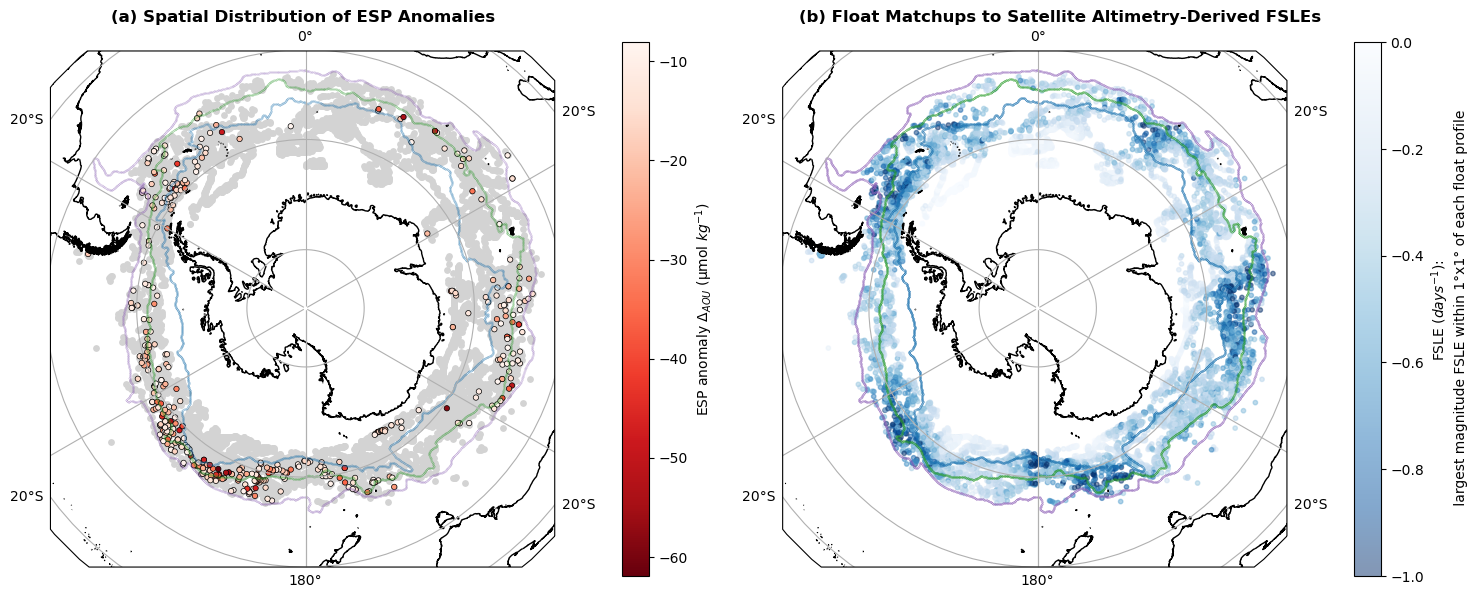

In [28]:
fig = plt.figure(figsize=(15,10));
gs = fig.add_gridspec(ncols=2, nrows=1);

proj = ccrs.Orthographic(central_longitude=0, central_latitude = -90)
data_crs = ccrs.PlateCarree()

ax1 = fig.add_subplot(gs[0,0],projection=proj);
ax1.coastlines(resolution='10m')
ax1.gridlines(draw_labels=True)

ax1.scatter(lons_all, lats_all, c = 'lightgray', transform=data_crs, s=15)
anommap = ax1.scatter(anoms.Lon, anoms.Lat, c = anoms.AOU_anomaly, cmap='Reds_r', edgecolor='black',linewidth=0.5,transform=data_crs, s=15)
cb = plt.colorbar(anommap, shrink=0.55,pad=0.1)
cb.set_label(label='ESP anomaly $Δ_{AOU}$ (µmol $kg^{-1}$)')
ax1.scatter(fronts.LonPF,fronts.LatPF,c='tab:green',transform=data_crs,s=0.025,alpha=0.4)
ax1.scatter(fronts.LonSAF,fronts.LatSAF,c='tab:purple',transform=data_crs,s=0.025,alpha=0.4)
ax1.scatter(fronts.LonSACCF,fronts.LatSACCF,c='tab:blue',transform=data_crs,s=0.025,alpha=0.4)
ax1.set_title('(a) Spatial Distribution of ESP Anomalies',fontweight='bold',x=0.5)
ax1.set_extent([-180, 180, -90, -40], crs=data_crs)

ax2 = fig.add_subplot(gs[0,1],projection=proj);
ax2.coastlines(resolution='10m')
ax2.gridlines(draw_labels=True)

ax2.scatter(profsummaries[profsummaries['fsle_max_min']>-0.2].Lon, profsummaries[profsummaries['fsle_max_min']>-0.2].Lat, c = profsummaries[profsummaries['fsle_max_min']>-0.2].fsle_max_min, cmap='Blues_r', transform=data_crs,vmin=-1, vmax=0,alpha=0.5,s=10)
fslemap = ax2.scatter(profsummaries[profsummaries['fsle_max_min']<=-0.2].Lon, profsummaries[profsummaries['fsle_max_min']<=-0.2].Lat, c = profsummaries[profsummaries['fsle_max_min']<-0.2].fsle_max_min, cmap='Blues_r', transform=data_crs,vmin=-1, vmax=0,alpha=0.5,s=10)
cb = plt.colorbar(fslemap, shrink=0.55,pad=0.1)
cb.set_label(label='FSLE ($days^{-1})$: \n largest magnitude FSLE within 1°x1° of each float profile')
ax2.scatter(fronts.LonPF,fronts.LatPF,c='tab:green',transform=data_crs,s=0.025,alpha=0.8)
ax2.scatter(fronts.LonSAF,fronts.LatSAF,c='tab:purple',transform=data_crs,s=0.025,alpha=0.8)
ax2.scatter(fronts.LonSACCF,fronts.LatSACCF,c='tab:blue',transform=data_crs,s=0.025,alpha=0.8)
ax2.set_title('(b) Float Matchups to Satellite Altimetry-Derived FSLEs',fontweight='bold',x=0.55)
ax2.set_extent([-180, 180, -90, -40], crs=data_crs)

plt.subplots_adjust(wspace=0.1, hspace=0)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
fig.savefig('figures/figure2_map.png',bbox_inches='tight')

## Figure 3: Seasonality

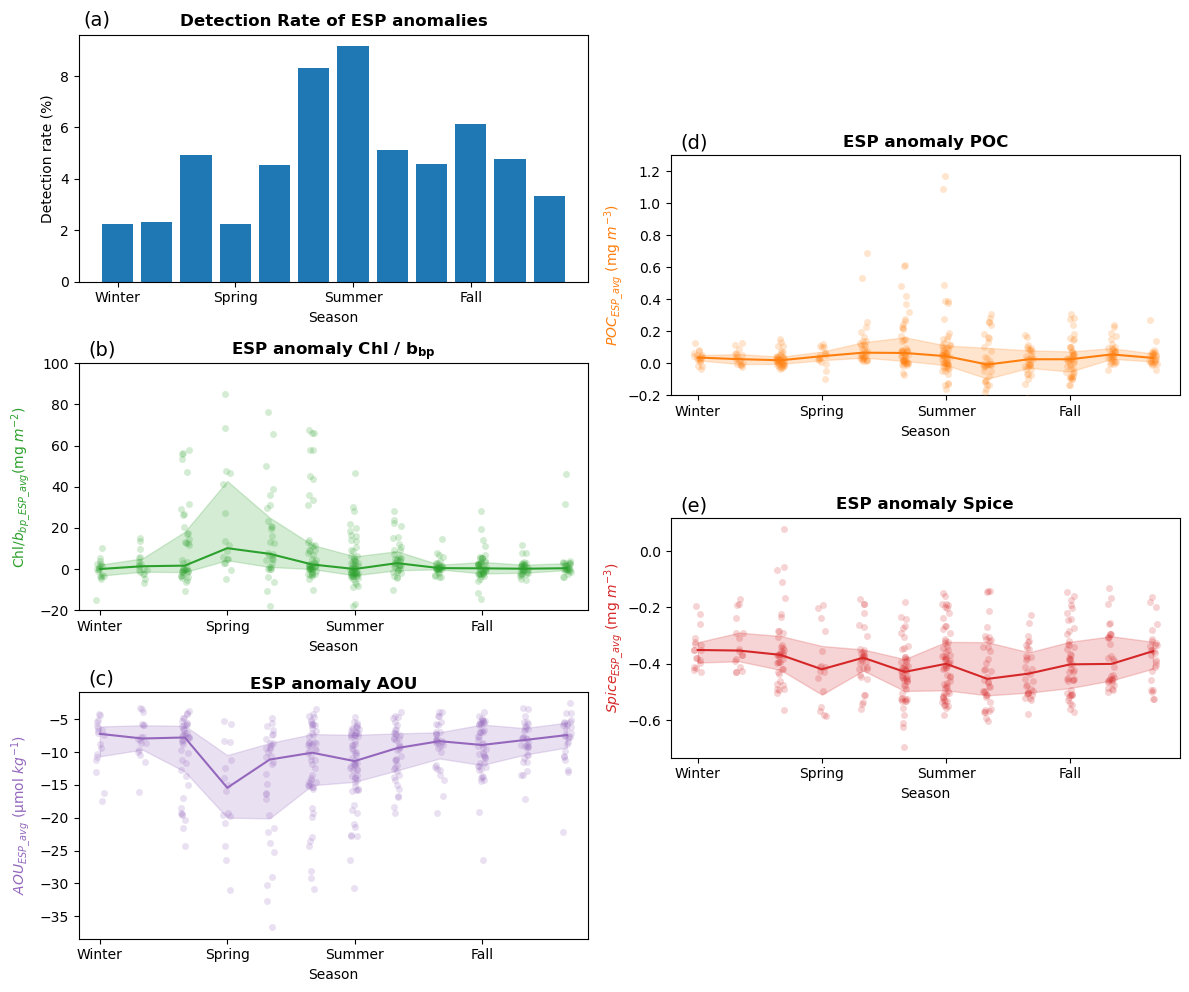

In [35]:
warnings.filterwarnings("ignore")
fig = plt.figure(figsize=(12,10));
gs = fig.add_gridspec(ncols=2, nrows=3);


########################### Number of events
ax1 = fig.add_subplot(gs[0, 0]);
ax1.bar(x=np.arange(1,13),height=anoms.groupby('month_winter0').size()/profsummaries.groupby('month_winter0').size()*100)
ax1.set_xlabel('Season')
ax1.set_xticks([1,4,7,10])
ax1.set_xticklabels(['Winter','Spring','Summer','Fall'])
ax1.set_ylabel('Detection rate (%)')
ax1.set_title('Detection Rate of ESP anomalies',fontweight='bold')


######################### Chl/bbp ratio 

ax2 = fig.add_subplot(gs[1, 0]);
ax2.plot([str(x) for x in range(6,18)],anoms.groupby('month_winter0').median()['chl_bbp_ratio_anom_norm'],c='tab:green')
ax2.fill_between([str(x) for x in range(6,18)],anoms.groupby('month_winter0').quantile(q=0.25)['chl_bbp_ratio_anom_norm'],anoms.groupby('month_winter0').quantile(q=0.75)['chl_bbp_ratio_anom_norm'],color='tab:green',alpha=0.2)
sns.stripplot(x='month_winter0', y="chl_bbp_ratio_anom_norm", data=anoms, c='tab:green',jitter=True,alpha=0.2,ax=ax2)
ax2.set_ylabel('Chl/$b_{bp\_ESP\_avg}$(mg $m^{-2}$)',color='tab:green')
ax2.set_xlabel('Season')
ax2.set_xticks([0,3,6,9])
ax2.set_ylim(-20,100)
ax2.set_xticklabels(['Winter','Spring','Summer','Fall'])
ax2.set_title('ESP anomaly Chl / $\mathbf{b_{bp}}$',fontweight='bold')

############################ AOU


ax3 = fig.add_subplot(gs[2, 0]);
ax3.plot([str(x) for x in range(6,18)],anoms.groupby('month_winter0').median()['integrated_AOU_anom_norm'],c='tab:purple')
ax3.fill_between([str(x) for x in range(6,18)],anoms.groupby('month_winter0').quantile(q=0.25)['integrated_AOU_anom_norm'],anoms.groupby('month_winter0').quantile(q=0.75)['integrated_AOU_anom_norm'],color='tab:purple',alpha=0.2)
sns.stripplot(x='month_winter0', y="integrated_AOU_anom_norm", data=anoms, c='tab:purple',jitter=True,alpha=0.2,ax=ax3)
ax3.set_ylabel('$AOU_{ESP\_avg}$ (µmol $kg^{-1}$)',color='tab:purple')
ax3.set_xlabel('Season')
ax3.set_xticks([0,3,6,9])
ax3.set_xticklabels(['Winter','Spring','Summer','Fall'])
ax3.set_title('ESP anomaly AOU',fontweight='bold',pad=-30)

########################### POC
gs00 = matplotlib.gridspec.GridSpecFromSubplotSpec(150,1, subplot_spec=gs[0:3,1])

ax4 = fig.add_subplot(gs00[20:60,0]);
ax4.plot([str(x) for x in range(6,18)],anoms.groupby('month_winter0').median()['integrated_POC_anom_norm'],c='tab:orange')
sns.stripplot(x='month_winter0', y="integrated_POC_anom_norm", data=anoms, c='tab:orange',jitter=True,alpha=0.2,ax=ax4)
ax4.fill_between([str(x) for x in range(6,18)],anoms.groupby('month_winter0').quantile(q=0.25)['integrated_POC_anom_norm'],anoms.groupby('month_winter0').quantile(q=0.75)['integrated_POC_anom_norm'],color='tab:orange',alpha=0.2)
ax4.set_ylabel('$POC_{ESP\_avg}$ (mg $m^{-3}$)',color='tab:orange', labelpad=0)
ax4.set_xlabel('Season')
ax4.set_xticks([0,3,6,9])
ax4.set_xticklabels(['Winter','Spring','Summer','Fall'])
ax4.set_ylim(-0.2,1.3)
ax4.set_title('ESP anomaly POC',fontweight='bold')

########################### Spice

ax5 = fig.add_subplot(gs00[80:120,0]);
ax5.plot([str(x) for x in range(6,18)],anoms.groupby('month_winter0').median()['integrated_spice_anom_norm'],c='tab:red')
sns.stripplot(x='month_winter0', y="integrated_spice_anom_norm", data=anoms, c='tab:red',jitter=True,alpha=0.2,ax=ax5)
ax5.fill_between([str(x) for x in range(6,18)],anoms.groupby('month_winter0').quantile(q=0.25)['integrated_spice_anom_norm'],anoms.groupby('month_winter0').quantile(q=0.75)['integrated_spice_anom_norm'],color='tab:red',alpha=0.2)
ax5.set_ylabel('$Spice_{ESP\_avg}$ (mg $m^{-3}$)',color='tab:red', labelpad=0)
ax5.set_xlabel('Season')
ax5.set_xticks([0,3,6,9])
ax5.set_xticklabels(['Winter','Spring','Summer','Fall'])
ax5.set_title('ESP anomaly Spice',fontweight='bold')





ax1.text(.01, 1.1, '(a)', ha='left', va='top', transform=ax1.transAxes,fontsize=14)
ax2.text(.02, 1.09, '(b)', ha='left', va='top', transform=ax2.transAxes,fontsize=14)
ax3.text(.02, 1.09, '(c)', ha='left', va='top', transform=ax3.transAxes,fontsize=14)
ax4.text(.02, 1.09, '(d)', ha='left', va='top', transform=ax4.transAxes,fontsize=14)
ax5.text(.02, 1.09, '(e)', ha='left', va='top', transform=ax5.transAxes,fontsize=14)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
fig.savefig('figures/figure3_seasonality.png',bbox_inches='tight')

In [36]:
print('chl/bbp axis limits show ', len(anoms[(anoms['chl_bbp_ratio_anom_norm']<100)&(anoms['chl_bbp_ratio_anom_norm']>-20)])/len(anoms[np.isfinite(anoms['chl_bbp_ratio_anom_norm'])& ~np.isnan(anoms['chl_bbp_ratio_anom_norm'])])*100, '% of data')
print('POC axis limits show ', len(anoms[(anoms['integrated_POC_anom_norm']<1.2)&(anoms['integrated_POC_anom_norm']>-0.2)])/len(anoms[np.isfinite(anoms['integrated_POC_anom_norm'])& ~np.isnan(anoms['integrated_POC_anom_norm'])])*100, '% of data')
                                                                                                    

chl/bbp axis limits show  98.29268292682927 % of data
POC axis limits show  98.04878048780488 % of data


## Supporting Information Figure S2: surface vs mesopelagic chl/bbp 

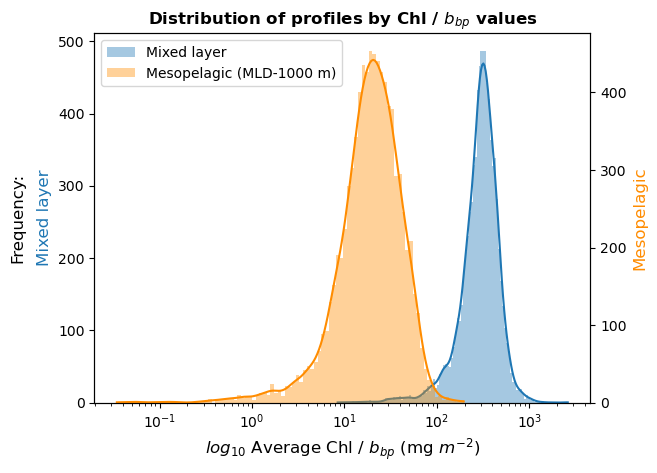

In [71]:
ax = sns.histplot(data=profsummaries[np.isfinite(profsummaries['MLD_chl_bbp_ratio_norm'])&~np.isnan(profsummaries['MLD_chl_bbp_ratio_norm'])&(profsummaries['MLD_chl_bbp_ratio_norm']>0)],x='MLD_chl_bbp_ratio_norm',log_scale=10,kde='true',edgecolor='none',alpha=0.4,label='Mixed layer')
ax.set_ylabel('Mixed layer',size=12,color='tab:blue')
ax1 = ax.twinx()
sns.histplot(data=profsummaries[np.isfinite(profsummaries['Deep_chl_bbp_ratio_norm'])&~np.isnan(profsummaries['Deep_chl_bbp_ratio_norm'])&(profsummaries['Deep_chl_bbp_ratio_norm']>0)],x='Deep_chl_bbp_ratio_norm',log_scale=10,color='darkorange',ax=ax1,kde='True',edgecolor='none',alpha=0.4, label='Mesopelagic (MLD-1000 m)')
ax1.set_ylabel('Mesopelagic',size=12,color='darkorange')
ax.set_xlabel('$log_{10}$ Average Chl / $b_{bp}$ (mg $m^{-2}$)',size=12)
ax.text(-0.17, 0.5, 'Frequency:', ha='left', va='center', transform=ax1.transAxes,fontsize=12,rotation=90)

# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines1, labels1 = ax1.get_legend_handles_labels()
ax.legend(lines + lines1, labels + labels1, loc=0)
ax.set_title('Distribution of profiles by Chl / $b_{bp}$ values',fontweight='bold')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
fig.savefig('figures/figureS2_chlbbp_depth.png',bbox_inches='tight')

## Supporting Information Figure S3: ambient mesopelagic values

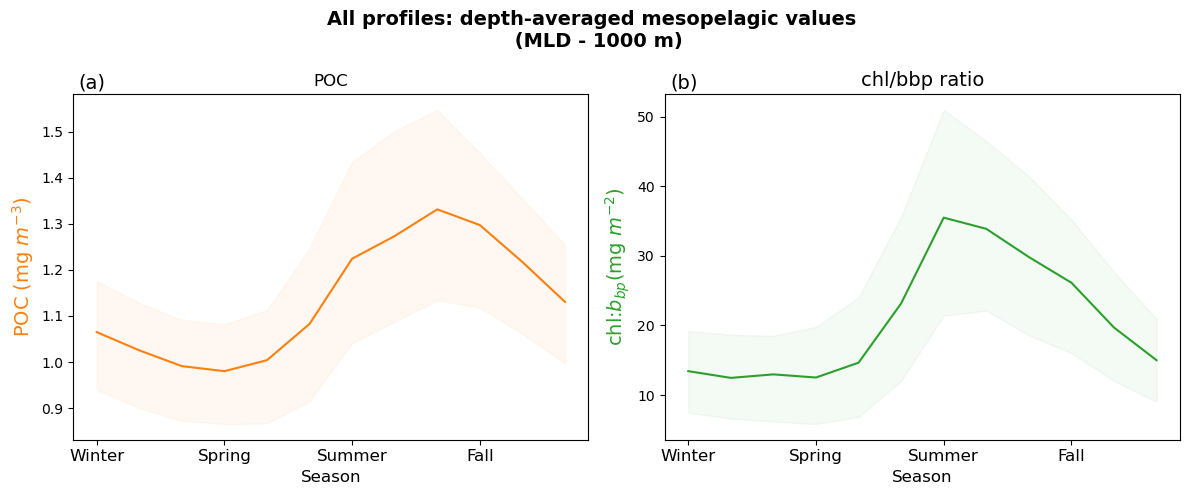

In [70]:
warnings.filterwarnings("ignore")
fig = plt.figure(figsize=(12,5));
gs = fig.add_gridspec(ncols=2, nrows=1);


######################### POC 
profsummaries["depth_between_MLD_1000"] = 1000 - profsummaries['MLD']
profsummaries['Deep_integrated_POC_norm'] = profsummaries['Deep_integrated_POC']/profsummaries['depth_between_MLD_1000']

ax1 = fig.add_subplot(gs[0, 0]);
ax1.plot(profsummaries.groupby('month_winter0').median()['Deep_integrated_POC_norm'],c='tab:orange')
ax1.fill_between(range(6,18),profsummaries.groupby('month_winter0').quantile(q=0.25)['Deep_integrated_POC_norm'],profsummaries.groupby('month_winter0').quantile(q=0.75)['Deep_integrated_POC_norm'],color='tab:orange',alpha=0.05)
ax1.set_ylabel('POC (mg $m^{-3}$)',color='tab:orange',size=14)
ax1.set_xlabel('Season',size=12)
ax1.set_xticks([6,9,12,15])
ax1.set_xticklabels(['Winter','Spring','Summer','Fall'],size=12)
ax1.set_title('POC')

############################ Chl/bbp ratio 
profsummaries['Deep_chl_bbp_ratio_norm'] = profsummaries['Deep_chl_bbp_ratio']/profsummaries['depth_between_MLD_1000']

ax2 = fig.add_subplot(gs[0, 1]);
ax2.plot(profsummaries.groupby('month_winter0').median()['Deep_chl_bbp_ratio_norm'],c='tab:green')
ax2.fill_between(range(6,18),profsummaries.groupby('month_winter0').quantile(q=0.25)['Deep_chl_bbp_ratio_norm'],profsummaries.groupby('month_winter0').quantile(q=0.75)['Deep_chl_bbp_ratio_norm'],color='tab:green',alpha=0.05)
ax2.set_ylabel('chl:$b_{bp}$(mg $m^{-2}$)',size=14,color='tab:green')
ax2.set_xlabel('Season',size=12)
ax2.set_xticks([6,9,12,15])
ax2.set_xticklabels(['Winter','Spring','Summer','Fall'],size=12)
ax2.set_title('chl/bbp ratio',size=14)

ax1.text(.01, 1.06, '(a)', ha='left', va='top', transform=ax1.transAxes,fontsize=14)
ax2.text(.01, 1.06, '(b)', ha='left', va='top', transform=ax2.transAxes,fontsize=14)

fig.suptitle('All profiles: depth-averaged mesopelagic values \n (MLD - 1000 m)',fontweight='bold',fontsize=14)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
fig.savefig('figures/figureS3_ambient-bgc.png',bbox_inches='tight')

## Supporting Information Figure S4: Spikes

In [64]:
profsummaries_navis = profsummaries[profsummaries['Float'].isin(navis_floats)]

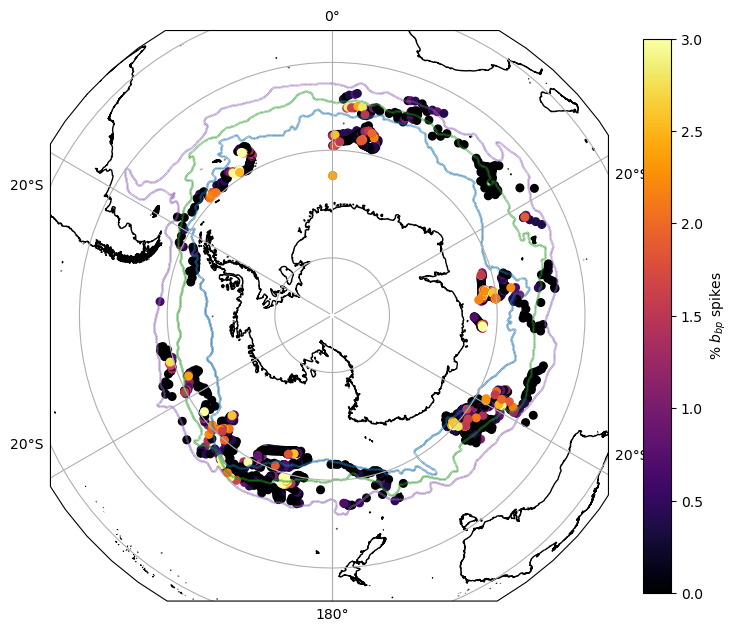

In [65]:
# Plot the anomaly coordinates

# define the projection of the map and the transormation of the data
proj = ccrs.Orthographic(central_longitude=0, central_latitude = -90)
data_crs = ccrs.PlateCarree()

fig = plt.figure(figsize=(9,9))
ax = plt.axes(projection=proj)
ax.coastlines(resolution='10m')
ax.gridlines(draw_labels=True)
#ax.set_facecolor('lightgray')

plt.scatter(profsummaries_navis[profsummaries_navis['mesopelagic_spike_percent_bbp']<1.5].Lon, profsummaries_navis[profsummaries_navis['mesopelagic_spike_percent_bbp']<1.5].Lat, c = profsummaries_navis[profsummaries_navis['mesopelagic_spike_percent_bbp']<1.5].mesopelagic_spike_percent_bbp, cmap='inferno', transform=data_crs, s=30,vmin=0,vmax=3)
plt.scatter(profsummaries_navis[profsummaries_navis['mesopelagic_spike_percent_bbp']>=1.5].Lon, profsummaries_navis[profsummaries_navis['mesopelagic_spike_percent_bbp']>=1.5].Lat, c = profsummaries_navis[profsummaries_navis['mesopelagic_spike_percent_bbp']>=1.5].mesopelagic_spike_percent_bbp, cmap='inferno', transform=data_crs, s=30,vmin=0,vmax=3)
#plt.scatter(profsummaries_navis.Lon, profsummaries_navis.Lat, c = profsummaries_navis.mesopelagic_spike_percent_bbp, cmap='inferno', transform=data_crs, s=30,vmin=0,vmax=8)
plt.colorbar(shrink=0.8,label='% $b_{bp}$ spikes')
plt.scatter(fronts.LonPF,fronts.LatPF,c='tab:green',transform=data_crs,s=0.05,alpha=0.4)
plt.scatter(fronts.LonSAF,fronts.LatSAF,c='tab:purple',transform=data_crs,s=0.05,alpha=0.4)
plt.scatter(fronts.LonSACCF,fronts.LatSACCF,c='tab:blue',transform=data_crs,s=0.05,alpha=0.4)
#plt.scatter(fronts.LonSB,fronts.LatSB,c='tab:purple',transform=data_crs,s=1)

ax.set_extent([-180, 180, -90, -30], crs=data_crs)

In [66]:
spikes_bbp = profsummaries[~np.isnan(profsummaries['mesopelagic_spike_percent_bbp'])][['mesopelagic_spike_percent_bbp','month_winter0','month']]
spikes_bbp['Spikes'] = 'bbp'
spikes_chl = profsummaries[~np.isnan(profsummaries['mesopelagic_spike_percent_bbp'])][['mesopelagic_spike_percent_chl','month_winter0','month']]
spikes_chl['Spikes'] = 'chl'
spikes=pd.concat([spikes_bbp,spikes_chl])

spikepercents = []
for index,row in spikes.iterrows():
    if row['Spikes']=='bbp':
        spikepercents.append(row.mesopelagic_spike_percent_bbp)
    elif row['Spikes']=='chl':
        spikepercents.append(row.mesopelagic_spike_percent_chl)
        
spikes['mesopelagic_spike_percent']=spikepercents
spikes = spikes.drop(columns=['mesopelagic_spike_percent_bbp','mesopelagic_spike_percent_chl'])

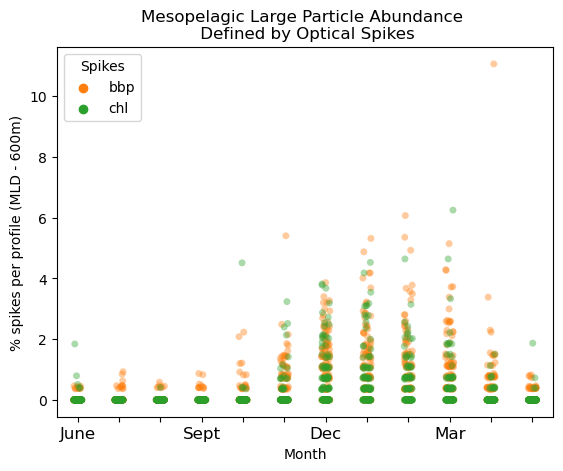

In [68]:
sns.stripplot(x="month_winter0", y="mesopelagic_spike_percent", data=spikes, hue='Spikes', palette=['tab:orange','tab:green'], jitter=True,alpha=0.4)
ax = plt.gca();
ax.set_ylabel('% spikes per profile (MLD - 600m)');
ax.set_xlabel('Month');
#ax.set_xticks([0,3,6,9]);
ax.set_xticklabels(['June','','','Sept','','','Dec','','','Mar','',''],size=12);
ax.set_title('Mesopelagic Large Particle Abundance \n Defined by Optical Spikes')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
fig.savefig('figures/figureS4_spikes.png',bbox_inches='tight')

### Example profiles: spikes

In [45]:
db, spicebin3, sigmatheta_bin3, aou_bin3, poc_bin3, chl_bin3 ,bbp_bin3,chl_bbp_ratio3 = calculateFloatVars('5904672',reorder=False)

In [46]:
bbp_despiked = db.b_bp700.rolling(N_LEVELS=5,center=True,min_periods=3).median()
bbp_despiked = bbp_despiked.rolling(N_LEVELS=7,center=True,min_periods=3).mean()
bbp_spikes = db.b_bp700 - bbp_despiked

chl_despiked = db.Chl_a.rolling(N_LEVELS=5,center=True,min_periods=3).median()
chl_despiked = chl_despiked.rolling(N_LEVELS=7,center=True,min_periods=3).mean()
chl_spikes = db.Chl_a - chl_despiked

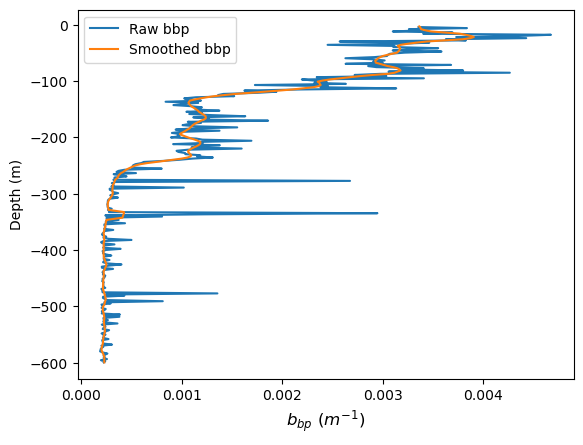

In [47]:
plt.plot(db.b_bp700[59][np.where(db.b_bp700[59].Depth<600)],-db.b_bp700[59][np.where(db.b_bp700[59].Depth<600)].Depth,label='Raw bbp')
plt.plot(bbp_despiked[59][np.where(bbp_despiked[59].Depth<600)],-bbp_despiked[59][np.where(bbp_despiked[59].Depth<600)].Depth,label='Smoothed bbp')
plt.xlabel('$b_{bp}$ ($m^{-1}$)',size=12)
plt.ylabel('Depth (m)')
plt.legend();

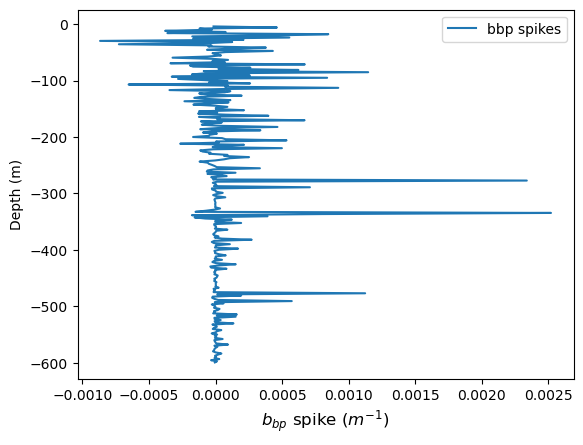

In [48]:
plt.plot(bbp_spikes[59][np.where(bbp_spikes[59].Depth<600)],-bbp_spikes[59][np.where(bbp_spikes[59].Depth<600)].Depth,label='bbp spikes')
plt.xlabel('$b_{bp}$ spike ($m^{-1}$)',size=12)
plt.ylabel('Depth (m)')
plt.legend();

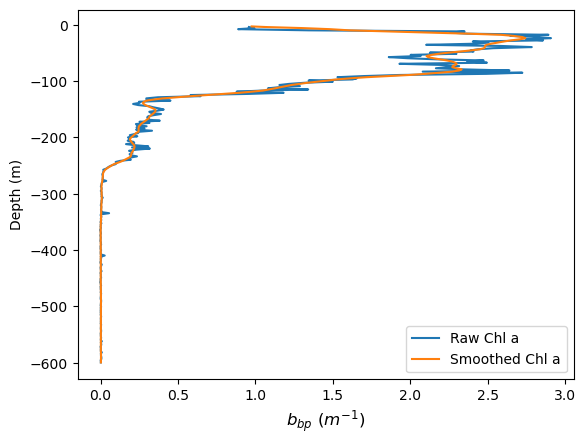

In [49]:
plt.plot(db.Chl_a[59][np.where(db.Chl_a[59].Depth<600)],-db.Chl_a[59][np.where(db.Chl_a[59].Depth<600)].Depth,label='Raw Chl a')
plt.plot(chl_despiked[59][np.where(chl_despiked[59].Depth<600)],-chl_despiked[59][np.where(chl_despiked[59].Depth<600)].Depth,label='Smoothed Chl a')
plt.xlabel('$b_{bp}$ ($m^{-1}$)',size=12)
plt.ylabel('Depth (m)')
plt.legend();

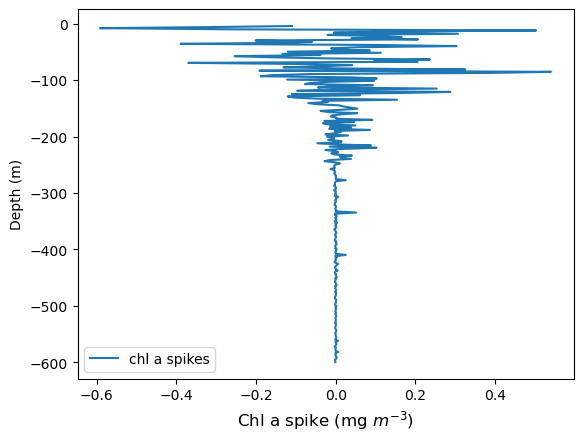

In [50]:
plt.plot(chl_spikes[59][np.where(chl_spikes[59].Depth<600)],-chl_spikes[59][np.where(chl_spikes[59].Depth<600)].Depth,label='chl a spikes')
plt.xlabel('Chl a spike (mg $m^{-3}$)',size=12)
plt.ylabel('Depth (m)')
plt.legend();

## Figure 4: mechanisms

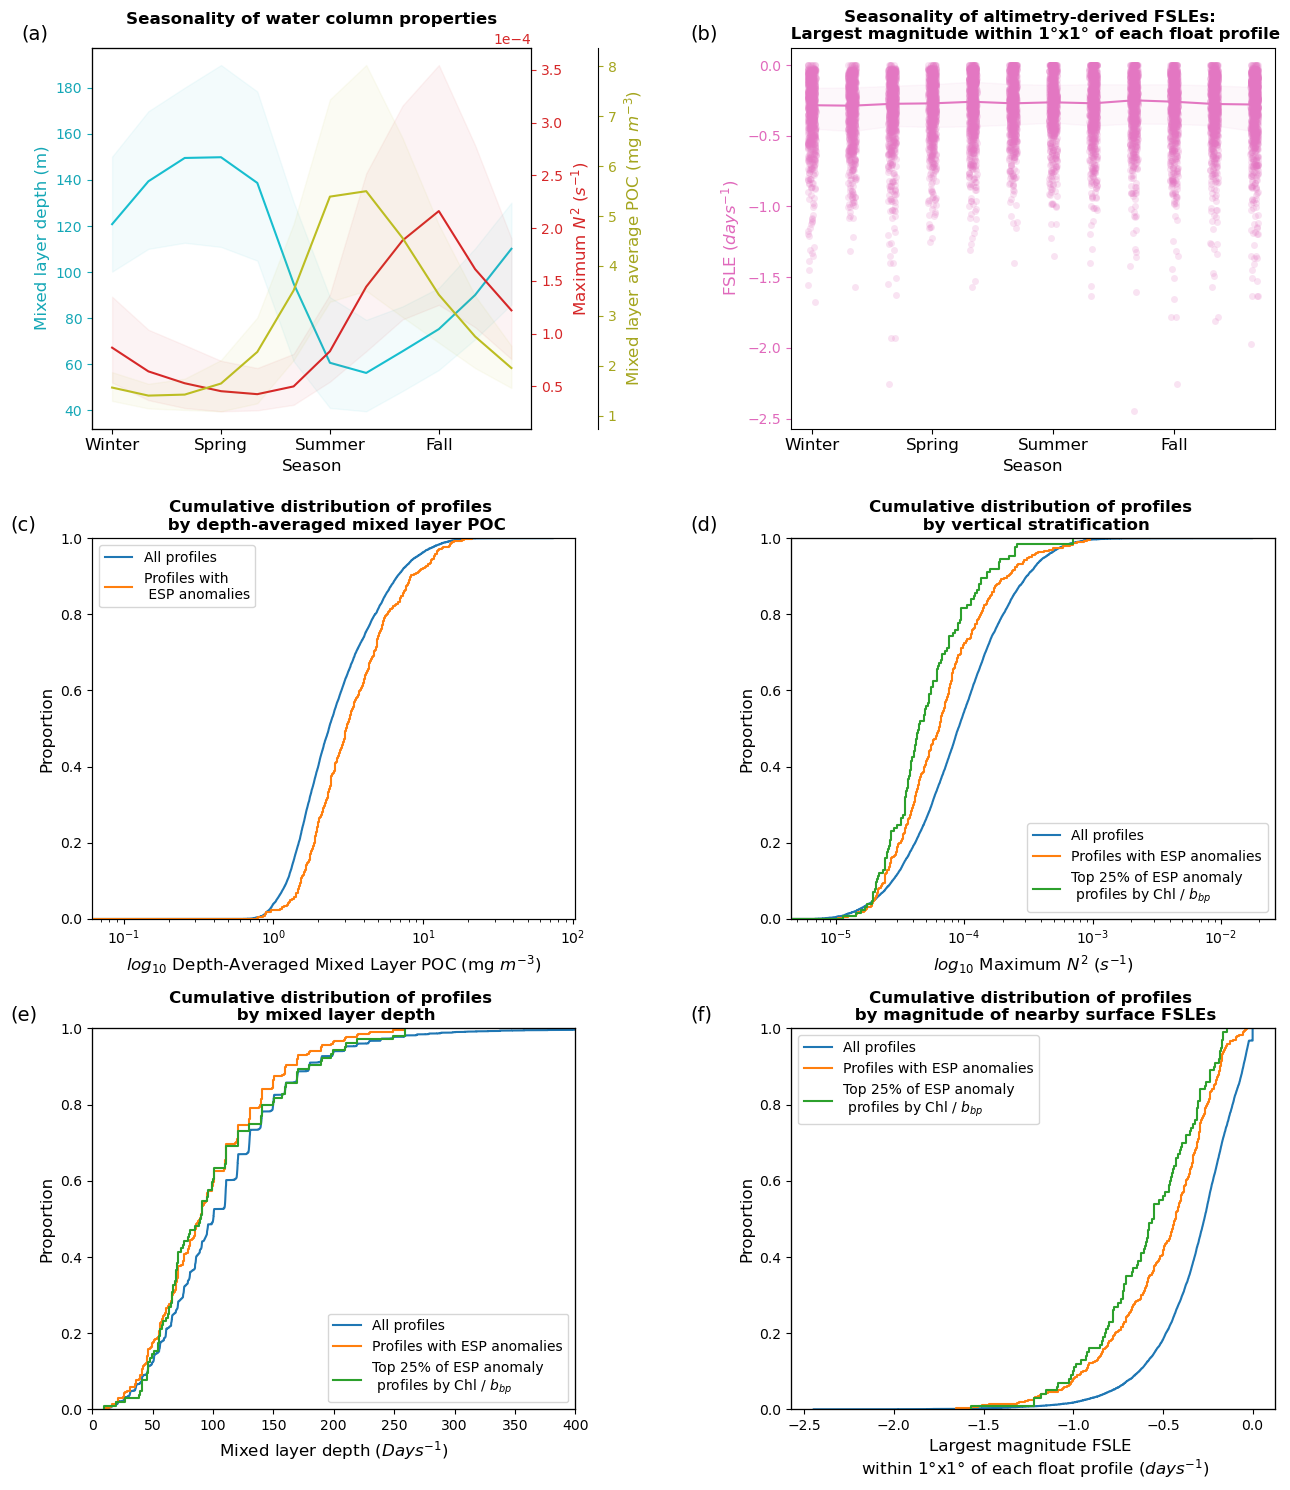

In [69]:
warnings.filterwarnings("ignore")
fig = plt.figure(figsize=(15,15));
gs = fig.add_gridspec(ncols=2, nrows=3);


########################### Seasonality MLD / maxN2 / surface POC
gs00 = matplotlib.gridspec.GridSpecFromSubplotSpec(1,160, subplot_spec=gs[0,0])

ax1 = fig.add_subplot(gs00[0,0:100]);
ax1.plot(profsummaries.groupby('month_winter0').median()['MLD'],c='tab:cyan')
ax1.fill_between(range(6,18),profsummaries.groupby('month_winter0').quantile(q=0.25)['MLD'],profsummaries.groupby('month_winter0').quantile(q=0.75)['MLD'],color='tab:cyan',alpha=0.05)
ax1.set_xlabel('Season',size=12)
ax1.set_xticks([6,9,12,15])
ax1.set_xticklabels(['Winter','Spring','Summer','Fall'],size=12)
ax1.set_ylabel('Mixed layer depth (m)',fontsize=12,color=lighten_color('tab:cyan', amount=1.1))
ax1.tick_params(axis='y', colors=lighten_color('tab:cyan', amount=1.1)) 
ax11 = ax1.twinx()
ax11.plot(profsummaries.groupby('month_winter0').median()['Max_N2'],c='tab:red')
ax11.fill_between(range(6,18),profsummaries.groupby('month_winter0').quantile(q=0.25)['Max_N2'],profsummaries.groupby('month_winter0').quantile(q=0.75)['Max_N2'],color='tab:red',alpha=0.05)
ax11.set_ylabel('Maximum $N^{2}$ ($s^{-1}$)',fontsize=12,color='tab:red')
ax11.tick_params(axis='y', colors='tab:red') 
ax11.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax12 = ax1.twinx()
ax12.spines.right.set_position(("axes", 1.152))
ax12.plot(profsummaries.groupby('month_winter0').median()['MLD_integrated_POC_norm'],c='tab:olive')
ax12.fill_between(range(6,18),profsummaries.groupby('month_winter0').quantile(q=0.25)['MLD_integrated_POC_norm'],profsummaries.groupby('month_winter0').quantile(q=0.75)['MLD_integrated_POC_norm'],color='tab:olive',alpha=0.05)
ax12.set_ylabel('Mixed layer average POC (mg $m^{-3}$)',fontsize=12,color=lighten_color('tab:olive', amount=1.1))
ax12.tick_params(axis='y', colors=lighten_color('tab:olive', amount=1.1)) 
ax1.set_title('Seasonality of water column properties',fontweight='bold')

########################### FSLE Seasonality
gs02 = matplotlib.gridspec.GridSpecFromSubplotSpec(1,160, subplot_spec=gs[0,1])
ax2 = fig.add_subplot(gs02[0,0:110]);
ax2.plot([str(x) for x in range(6,18)],profsummaries.groupby('month_winter0').median()['fsle_max_min'],c='tab:pink')
ax2.fill_between([str(x) for x in range(6,18)],profsummaries.groupby('month_winter0').quantile(q=0.25)['fsle_max_min'],profsummaries.groupby('month_winter0').quantile(q=0.75)['fsle_max_min'],color='tab:pink',alpha=0.05)
sns.stripplot(x='month_winter0', y="fsle_max_min", data=profsummaries, c='tab:pink',jitter=True,alpha=0.2,ax=ax2)
ax2.set_xlabel('Season',size=12)
ax2.set_xticks([0,3,6,9])
ax2.set_xticklabels(['Winter','Spring','Summer','Fall'],size=12)
ax2.set_ylabel('FSLE ($days^{-1}$)',fontsize=12,color=lighten_color('tab:pink', amount=1.1))
ax2.tick_params(axis='y', colors=lighten_color('tab:pink', amount=1.1)) 
ax2.set_title('Seasonality of altimetry-derived FSLEs: \n Largest magnitude within 1°x1° of each float profile',fontweight='bold')


########################### Surface POC distributions
gs03 = matplotlib.gridspec.GridSpecFromSubplotSpec(1,160, subplot_spec=gs[1,0])
ax3 = fig.add_subplot(gs03[0,0:110]);
ax3 = sns.ecdfplot(data=profsummaries[np.isfinite(profsummaries['MLD_integrated_POC_norm'])&(profsummaries['MLD_integrated_POC_norm']>0)],x='MLD_integrated_POC_norm',log_scale=10,label='All profiles')
ax3.set_ylabel('Proportion',size=12)
ax3.set_xlabel('$log_{10}$ Depth-Averaged Mixed Layer POC (mg $m^{-3}$)',size=12)
ax31 = ax3.twinx()
ax31.get_yaxis().set_ticks([])
sns.ecdfplot(data=profsummaries[(profsummaries['anomaly']=='y')&np.isfinite(profsummaries['MLD_integrated_POC_norm'])&(profsummaries['MLD_integrated_POC_norm']>0)],x='MLD_integrated_POC_norm',color='tab:orange',log_scale=10,label='Profiles with \n ESP anomalies',ax=ax31)


ax3lines, ax3labels = ax3.get_legend_handles_labels()
ax3lines1, ax3labels1 = ax31.get_legend_handles_labels()
ax3.legend(ax3lines + ax3lines1, ax3labels + ax3labels1, loc=0)
ax3.set_title('Cumulative distribution of profiles \n by depth-averaged mixed layer POC',fontweight='bold')

########################### maxN2 distributions
gs04 = matplotlib.gridspec.GridSpecFromSubplotSpec(1,160, subplot_spec=gs[1,1])

ax4 = fig.add_subplot(gs04[0,0:110]);
ax4 = sns.ecdfplot(data=profsummaries,x='Max_N2',log_scale=10,label='All profiles')
ax4.set_ylabel('Proportion',size=12)
ax41 = ax4.twinx()
ax41.get_yaxis().set_ticks([])
sns.ecdfplot(data=anoms,x='Max_N2',log_scale=10,color='tab:orange',ax=ax41,label='Profiles with ESP anomalies')
ax42 = ax4.twinx()
ax42.get_yaxis().set_ticks([])
sns.ecdfplot(data=anoms[anoms['floatstation'].isin(freshanoms)],x='Max_N2',log_scale=10,color='tab:green',ax=ax42,label='Top 25% of ESP anomaly \n profiles by Chl / $b_{bp}$')
ax4.set_xlabel('$log_{10}$ Maximum $N^{2}$ ($s^{-1}$)',size=12)

# ask matplotlib for the plotted objects and their labels
ax4lines, ax4labels = ax4.get_legend_handles_labels()
ax4lines1, ax4labels1 = ax41.get_legend_handles_labels()
ax4lines2, ax4labels2 = ax42.get_legend_handles_labels()
ax4.legend(ax4lines + ax4lines1 + ax4lines2, ax4labels + ax4labels1 + ax4labels2, loc=0)
ax4.set_title('Cumulative distribution of profiles \n by vertical stratification',fontweight='bold')

########################### MLD distributions
gs05 = matplotlib.gridspec.GridSpecFromSubplotSpec(1,160, subplot_spec=gs[2,0])
ax5 = fig.add_subplot(gs05[0,0:110]);
sns.ecdfplot(profsummaries.MLD,label='All profiles',ax=ax5)
ax5.set_ylabel('Proportion',size=12)
ax52=ax5.twinx()
ax52.get_yaxis().set_ticks([])
sns.ecdfplot(profsummaries[profsummaries['anomaly']=='y'].MLD,ax=ax52,color='tab:orange',label='Profiles with ESP anomalies')
ax53 = ax5.twinx()
ax53.get_yaxis().set_ticks([])
sns.ecdfplot(profsummaries[profsummaries['floatstation'].isin(freshanoms)].MLD,ax=ax53,color='tab:green',label='Top 25% of ESP anomaly \n profiles by Chl / $b_{bp}$')
ax5.set_xlabel('Mixed layer depth ($Days^{-1}$)',size=12)
ax5.set_title('Cumulative distribution of profiles \n by mixed layer depth',fontweight='bold')
ax5.set_xlim(0,400)

ax51lines, ax51labels = ax5.get_legend_handles_labels()
ax52lines, ax52labels = ax52.get_legend_handles_labels()
ax53lines, ax53labels = ax53.get_legend_handles_labels()
ax5.legend(ax51lines + ax52lines + ax53lines, ax51labels + ax52labels + ax53labels, loc='lower right')


########################### FSLE distributions
gs06 = matplotlib.gridspec.GridSpecFromSubplotSpec(1,160, subplot_spec=gs[2,1])
ax6 = fig.add_subplot(gs06[0,0:110]);
sns.ecdfplot(profsummaries.fsle_max_min,label='All profiles',ax=ax6)
ax6.set_ylabel('Proportion',size=12)
ax62=ax6.twinx()
ax62.get_yaxis().set_ticks([])
sns.ecdfplot(profsummaries[profsummaries['anomaly']=='y'].fsle_max_min,ax=ax62,color='tab:orange',label='Profiles with ESP anomalies')
ax63 = ax6.twinx()
ax63.get_yaxis().set_ticks([])
sns.ecdfplot(profsummaries[profsummaries['floatstation'].isin(freshanoms)].fsle_max_min,ax=ax63,color='tab:green',label='Top 25% of ESP anomaly \n profiles by Chl / $b_{bp}$')
ax6.set_xlabel('Largest magnitude FSLE \n within 1°x1° of each float profile ($days^{-1}$)',size=12)
ax6.set_title('Cumulative distribution of profiles \n by magnitude of nearby surface FSLEs',fontweight='bold')

ax61lines, ax61labels = ax6.get_legend_handles_labels()
ax62lines, ax62labels = ax62.get_legend_handles_labels()
ax63lines, ax63labels = ax63.get_legend_handles_labels()
ax6.legend(ax61lines + ax62lines + ax63lines, ax61labels + ax62labels + ax63labels, loc='upper left')


ax1.text(-.16, 1.06, '(a)', ha='left', va='top', transform=ax1.transAxes,fontsize=14)
ax2.text(-.21, 1.06, '(b)', ha='left', va='top', transform=ax2.transAxes,fontsize=14)
ax3.text(-.17, 1.06, '(c)', ha='left', va='top', transform=ax3.transAxes,fontsize=14)
ax4.text(-.21, 1.06, '(d)', ha='left', va='top', transform=ax4.transAxes,fontsize=14)
ax5.text(-.17, 1.06, '(e)', ha='left', va='top', transform=ax5.transAxes,fontsize=14)
ax6.text(-.21, 1.06, '(f)', ha='left', va='top', transform=ax6.transAxes,fontsize=14)

plt.subplots_adjust(hspace=4,wspace=0)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
fig.savefig('figures/figure4_mechanisms.png',bbox_inches='tight')

## Supporting Information Figure S5: Max N2 vs Chl/bbp

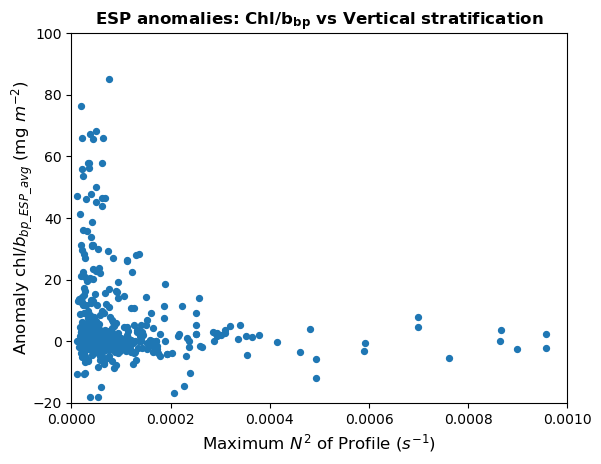

In [80]:
########################### Max N2 vs chl/bbp
plt.scatter(anoms.Max_N2, anoms.chl_bbp_ratio_anom_norm,s=18)
ax = plt.gca()
ax.set_ylim(-20,100)
ax.set_xlim(0,0.001)
ax.set_ylabel('Anomaly chl/$b_{bp\_ESP\_avg}$ (mg $m^{-2}$)',fontsize=12,labelpad = -2)
ax.set_xlabel('Maximum $N^{2}$ of Profile ($s^{-1}$)',fontsize=12)
ax.set_title('ESP anomalies: Chl/$\mathbf{b_{bp}}$ vs Vertical stratification',fontweight='bold')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
fig.savefig('figures/figureS5_chlbbp-vs-n2.png',bbox_inches='tight')

## Additional figures

### T/S diagrams

#### All profiles in the dataset

Text(0.5, 1.0, 'T/S Diagram: \n All Analyzed Profiles')

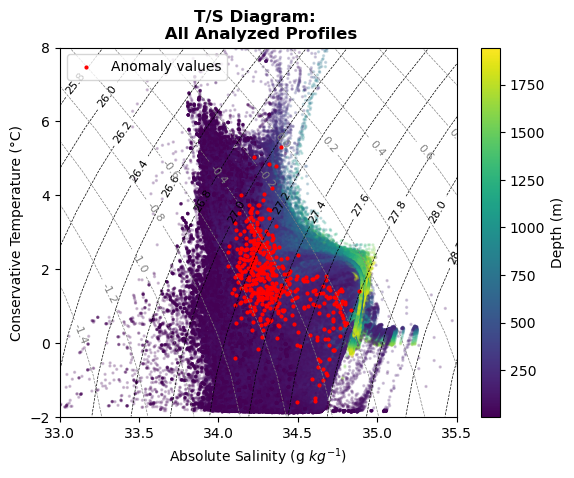

In [74]:
# Define the min / max values for plotting isopycnals
t_min = ts_all.Conservative_Temperature.min()-0.1
#t_max = ts_all.Conservative_Temperature.max()+0.1
t_max = 7+0.1
#s_min = ts_all.Absolute_Salinity.min()-0.1
s_min = 33-0.1
#s_max = ts_all.Absolute_Salinity.max()+0.1
s_max = 35+0.1

# Calculate how many gridcells we need in the x and y dimensions
xdim = int(np.ceil(s_max - s_min)/0.1)
ydim = int(np.ceil(t_max-t_min))
dens = np.zeros((int(ydim),int(xdim)))
spice = np.zeros((int(ydim),int(xdim)))

# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(0,ydim,ydim)+t_min
si = np.linspace(1,xdim,xdim)*0.1+s_min

# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        dens[j,i]=gsw.sigma0(si[i],ti[j])
        spice[j,i]=gsw.spiciness0(si[i],ti[j])
        
CS = plt.contour(si,ti,dens, linestyles='dashed', colors='k',levels=15,linewidths=0.5)
CS1 = plt.contour(si,ti,spice, linestyles='dashed', colors='gray',levels=15,linewidths=0.5)
plt.clabel(CS, fontsize=8, inline=1, fmt='%.1f') # Label every second level
plt.clabel(CS1, fontsize=8, inline=1, fmt='%.1f') # Label every second level
ts = plt.scatter(ts_all.Absolute_Salinity,ts_all.Conservative_Temperature,c=ts_all.Depth,alpha=0.2,s=2)
plt.scatter(anoms.Absolute_Salinity,anoms.Conservative_Temperature,c='red',s=4,label='Anomaly values')
cbar = plt.colorbar(ts,label='Depth (m)')
cbar.solids.set(alpha=1)
plt.xlim(33,35.5)
plt.ylim(-2,8)
plt.legend()
plt.ylabel("Conservative Temperature (\N{DEGREE SIGN}C)")
plt.xlabel("Absolute Salinity (g $kg^{-1}$)")
plt.title('T/S Diagram: \n All Analyzed Profiles',fontweight='bold')

#### Only profiles with ESP anomalies

Text(0.5, 1.0, 'T/S Diagram: \n Profiles with Subduction Anomalies')

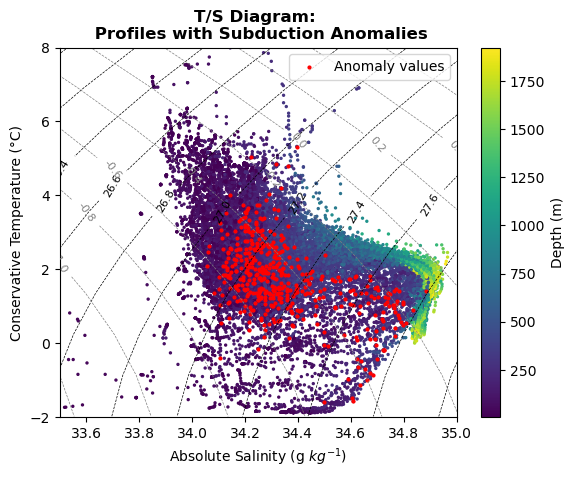

In [73]:
# Define the min / max values for plotting isopycnals
t_min = ts_all.Conservative_Temperature.min()-0.1
#t_max = ts_all.Conservative_Temperature.max()+0.1
t_max = 7+0.1
#s_min = ts_all.Absolute_Salinity.min()-0.1
s_min = 33-0.1
#s_max = ts_all.Absolute_Salinity.max()+0.1
s_max = 35+0.1

# Calculate how many gridcells we need in the x and y dimensions
xdim = int(np.ceil(s_max - s_min)/0.1)
ydim = int(np.ceil(t_max-t_min))
dens = np.zeros((int(ydim),int(xdim)))
spice = np.zeros((int(ydim),int(xdim)))

# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(0,ydim,ydim)+t_min
si = np.linspace(1,xdim,xdim)*0.1+s_min

# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        dens[j,i]=gsw.sigma0(si[i],ti[j])
        spice[j,i]=gsw.spiciness0(si[i],ti[j])
CS = plt.contour(si,ti,dens, linestyles='dashed', colors='k',levels=15,linewidths=0.5)
CS1 = plt.contour(si,ti,spice, linestyles='dashed', colors='gray',levels=15,linewidths=0.5)
plt.clabel(CS, fontsize=8, inline=1, fmt='%.1f') # Label every second level
plt.clabel(CS1, fontsize=8, inline=1, fmt='%.1f') # Label every second level
ts = plt.scatter(ts_all[ts_all['anomaly']=='y'].Absolute_Salinity,ts_all[ts_all['anomaly']=='y'].Conservative_Temperature,c=ts_all[ts_all['anomaly']=='y'].Depth,s=2)
plt.scatter(anoms.Absolute_Salinity,anoms.Conservative_Temperature,c='red',s=4,label='Anomaly values')
#plt.scatter(anoms[anoms['chl_bbp_ratio_anom_norm']>7].Absolute_Salinity,anoms[anoms['chl_bbp_ratio_anom_norm']>7].Conservative_Temperature,c='green',s=4)
#plt.scatter(anoms.integrated_S_total_norm,anoms.integrated_T_total_norm,c='red',s=4)
plt.colorbar(ts,label='Depth (m)')
plt.xlim(33.5,35)
plt.ylim(-2,8)
plt.legend()
plt.ylabel("Conservative Temperature (\N{DEGREE SIGN}C)")
plt.xlabel("Absolute Salinity (g $kg^{-1}$)")
plt.title('T/S Diagram: \n Profiles with Subduction Anomalies',fontweight='bold')

### EKE

In [75]:
import cdsapi

In [77]:
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'satellite-sea-level-global',
    {
        'version': 'vDT2021',
        'format': 'tgz',
        'variable': 'monthly_mean',
        'year': [
            '2008', '2009', '2010',
            '2011', '2012', '2013',
            '2014', '2015', '2016',
            '2017', '2018', '2019',
            '2020', '2021', '2022',
            '2023',
        ],
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
        ],
    },
    'download.tar.gz')

2024-03-25 11:42:29,258 INFO Welcome to the CDS
INFO:cdsapi:Welcome to the CDS
2024-03-25 11:42:29,261 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/satellite-sea-level-global
INFO:cdsapi:Sending request to https://cds.climate.copernicus.eu/api/v2/resources/satellite-sea-level-global
2024-03-25 11:42:29,462 INFO Request is queued
INFO:cdsapi:Request is queued
2024-03-25 11:42:30,633 INFO Request is running
INFO:cdsapi:Request is running
2024-03-25 11:43:45,617 INFO Request is completed
INFO:cdsapi:Request is completed
2024-03-25 11:43:45,627 INFO Downloading https://download-0005-clone.copernicus-climate.eu/cache-compute-0005/cache/data3/dataset-satellite-sea-level-global-845aee3e-8d57-426c-bcb7-94c36afb5150.tar.gz to download.tar.gz (496.9M)
INFO:cdsapi:Downloading https://download-0005-clone.copernicus-climate.eu/cache-compute-0005/cache/data3/dataset-satellite-sea-level-global-845aee3e-8d57-426c-bcb7-94c36afb5150.tar.gz to download.tar.gz (496.9M)
2024-0

Result(content_length=521024870,content_type=application/gzip,location=https://download-0005-clone.copernicus-climate.eu/cache-compute-0005/cache/data3/dataset-satellite-sea-level-global-845aee3e-8d57-426c-bcb7-94c36afb5150.tar.gz)

In [120]:
ekes = []

for index, row in profsummaries.iterrows():
    year = row['mon_day_yr'].year
    month = row['mon_day_yr'].month 
    
    if year==2023 and month>5:
        ekes.append(np.nan)
    
    else:
        month = f"{month:02}"
        lat = row['Lat']
        lon = row['Lat']
        
        ekedb = xr.open_dataset('EKE/dt_global_twosat_phy_l4_{}{}_vDT2021-M01.nc'.format(year,month))
        eke = ekedb.sel(latitude=lat,longitude=lon,method='nearest').eke.values[0]
        ekes.append(eke)

In [123]:
profsummaries['monthly_EKE'] = ekes

In [205]:
profsummaries['monthly_EKE_plus1'] = profsummaries['monthly_EKE']+.001

In [170]:
freshanoms = anoms[anoms['chl_bbp_ratio_anom_norm']>7]['floatstation'].to_list()

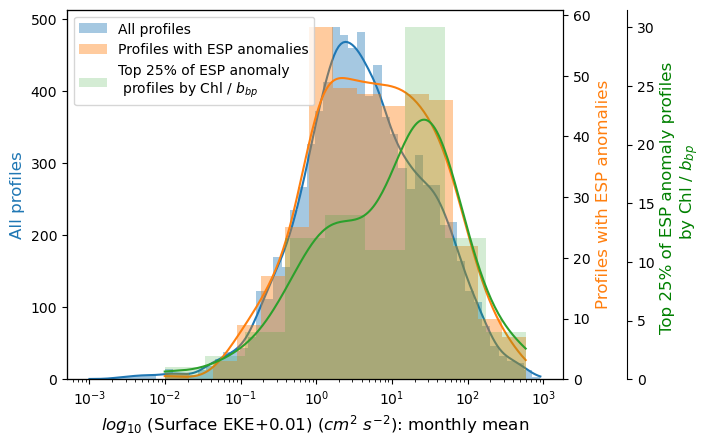

In [317]:
ax1 = sns.histplot(data=profsummaries,x='monthly_EKE_plus1',log_scale=10,kde=True,edgecolor=None,alpha=0.4,label='All profiles')
ax2 = ax1.twinx()
sns.histplot(data=profsummaries[profsummaries['anomaly']=='y'],x='monthly_EKE_plus1',log_scale=10,color='tab:orange',kde=True,edgecolor=None,alpha=0.4,label='Profiles with ESP anomalies',ax=ax2)
ax3 = ax1.twinx()
ax3.spines.right.set_position(("axes", 1.13))
sns.histplot(data=profsummaries[profsummaries['floatstation'].isin(freshanoms)],x='monthly_EKE_plus1',log_scale=10,color='tab:green',kde=True,edgecolor=None,alpha=0.2,label='Top 25% of ESP anomaly \n profiles by Chl / $b_{bp}$',ax=ax3)

ax1.set_ylabel('All profiles',size=12,color='tab:blue')
ax2.set_ylabel('Profiles with ESP anomalies',size=12,color='tab:orange')
ax3.set_ylabel('Top 25% of ESP anomaly profiles \n by Chl / $b_{bp}$',size=12,color='green')
ax1.set_xlabel('$log_{10}$ (Surface EKE+0.01) ($cm^{2}$ $s^{-2}$): monthly mean',fontsize=12)

# ask matplotlib for the plotted objects and their labels
ax1lines, ax1labels = ax1.get_legend_handles_labels()
ax2lines, ax2labels = ax2.get_legend_handles_labels()
ax3lines, ax3labels = ax3.get_legend_handles_labels()
plt.legend(ax1lines + ax2lines + ax3lines, ax1labels + ax2labels + ax3labels, loc=0)

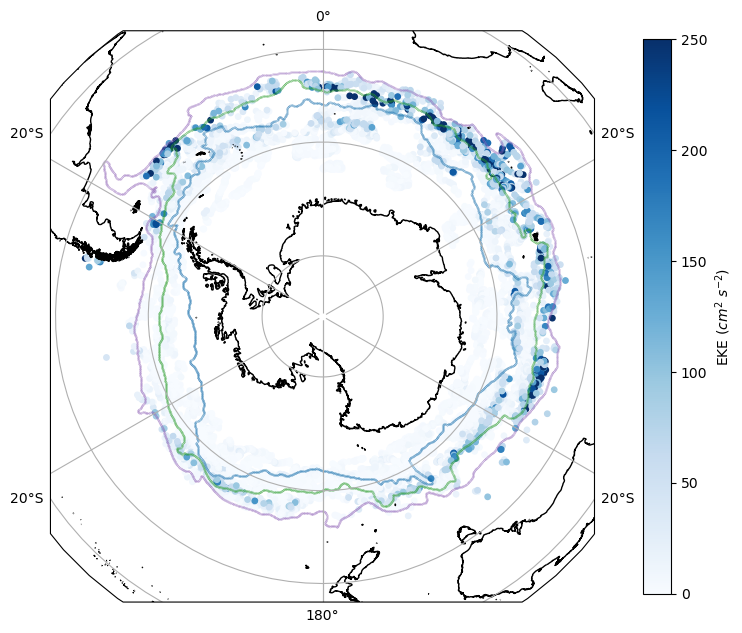

In [366]:
# Plot the anomaly coordinates

# define the projection of the map and the transormation of the data
proj = ccrs.Orthographic(central_longitude=0, central_latitude = -90)
data_crs = ccrs.PlateCarree()

fig = plt.figure(figsize=(9,9))
ax = plt.axes(projection=proj)
ax.coastlines(resolution='10m')
ax.gridlines(draw_labels=True)

#db = xr.open_dataset('SOCCOM_LoResQC_LIAR_19May2022_netcdf/5904677QC.nc')
plt.scatter(profsummaries[profsummaries['monthly_EKE']<50].Lon, profsummaries[profsummaries['monthly_EKE']<50].Lat, c = profsummaries[profsummaries['monthly_EKE']<50].monthly_EKE,vmin=0,vmax=250, transform=data_crs, s=15,cmap='Blues')
plt.scatter(profsummaries[profsummaries['monthly_EKE']>=50].Lon, profsummaries[profsummaries['monthly_EKE']>=50].Lat, c = profsummaries[profsummaries['monthly_EKE']>=50].monthly_EKE,vmin=0,vmax=250, transform=data_crs, s=15,cmap='Blues')
plt.colorbar(shrink=0.8,label='EKE ($cm^{2}$ $s^{-2}$)',pad=0.07)
plt.scatter(fronts.LonPF,fronts.LatPF,c='tab:green',transform=data_crs,s=0.05,alpha=0.4)
plt.scatter(fronts.LonSAF,fronts.LatSAF,c='tab:purple',transform=data_crs,s=0.05,alpha=0.4)
plt.scatter(fronts.LonSACCF,fronts.LatSACCF,c='tab:blue',transform=data_crs,s=0.05,alpha=0.4)
#plt.scatter(fronts.LonSB,fronts.LatSB,c='tab:purple',transform=data_crs,s=1)

ax.set_extent([-180, 180, -90, -35], crs=data_crs)

In [175]:
len(profsummaries.mon_day_yr.unique())

3417

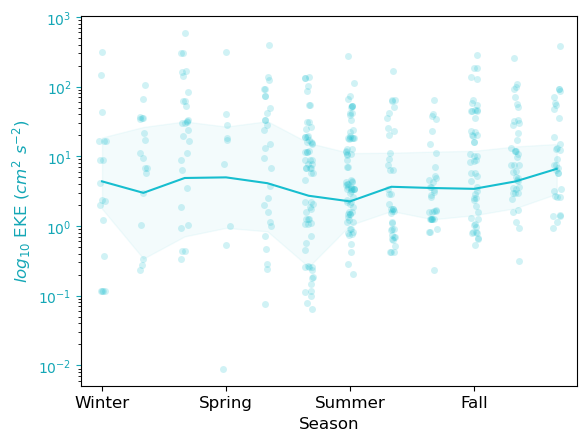

In [318]:
plt.plot([str(x) for x in range(6,18)],profsummaries.groupby('month_winter0').median()['monthly_EKE'],c='tab:cyan')
ax1 = plt.gca()
ax1.fill_between([str(x) for x in range(6,18)],profsummaries.groupby('month_winter0').quantile(q=0.25)['monthly_EKE'],profsummaries.groupby('month_winter0').quantile(q=0.75)['monthly_EKE'],color='tab:cyan',alpha=0.05)
sns.stripplot(x='month_winter0', y="monthly_EKE", data=anoms, c='tab:cyan',jitter=True,alpha=0.2,ax=ax1)
ax1.set_xlabel('Season',size=12)
ax1.set_xticks([0,3,6,9])
ax1.set_yscale('log')
#ax1.set_yscale(0,100)
ax1.set_xticklabels(['Winter','Spring','Summer','Fall'],size=12)
ax1.set_ylabel('$log_{10}$ EKE ($cm^{2}$ $s^{-2}$)',fontsize=12,color=lighten_color('tab:cyan', amount=1.1))
ax1.tick_params(axis='y', colors=lighten_color('tab:cyan', amount=1.1)) 

In [194]:
anoms['monthly_EKE'] = anoms.apply(lambda x: profsummaries[profsummaries['floatstation']==x['floatstation']].monthly_EKE.values[0],axis=1)

### Map of vertical stratification

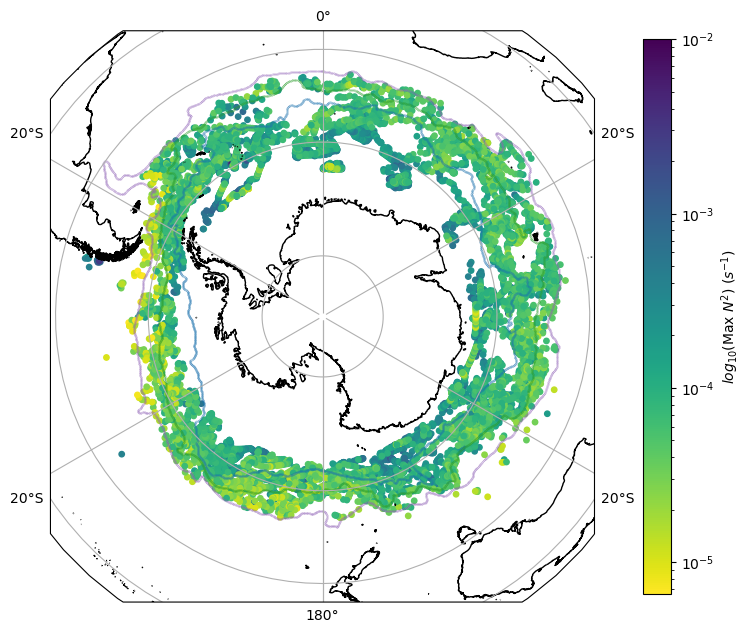

In [286]:
# Plot the anomaly coordinates

# define the projection of the map and the transormation of the data
proj = ccrs.Orthographic(central_longitude=0, central_latitude = -90)
data_crs = ccrs.PlateCarree()

fig = plt.figure(figsize=(9,9))
ax = plt.axes(projection=proj)
ax.coastlines(resolution='10m')
ax.gridlines(draw_labels=True)

#db = xr.open_dataset('SOCCOM_LoResQC_LIAR_19May2022_netcdf/5904677QC.nc')
#plt.scatter(profsummaries.Lon, profsummaries.Lat, c = profsummaries.Max_N2, transform=data_crs, s=10, norm=matplotlib.colors.LogNorm(vmin=10e-6,vmax=10e-1),cmap='viridis_r')
plt.scatter(profsummaries[profsummaries['Max_N2']>=1e-4].Lon, profsummaries[profsummaries['Max_N2']>=1e-4].Lat, c = profsummaries[profsummaries['Max_N2']>=1e-4].Max_N2,transform=data_crs, s=15, norm=matplotlib.colors.LogNorm(vmin=6.6e-6,vmax=1e-2),cmap='viridis_r')
plt.scatter(profsummaries[profsummaries['Max_N2']<1e-4].Lon, profsummaries[profsummaries['Max_N2']<1e-4].Lat, c = profsummaries[profsummaries['Max_N2']<1e-4].Max_N2, transform=data_crs, s=15, norm=matplotlib.colors.LogNorm(vmin=6.6e-6,vmax=1e-2),cmap='viridis_r')
plt.colorbar(shrink=0.8,label='$log_{10}$(Max $N^{2}$) ($s^{-1}$)',pad=0.07)
plt.scatter(fronts.LonPF,fronts.LatPF,c='tab:green',transform=data_crs,s=0.05,alpha=0.4)
plt.scatter(fronts.LonSAF,fronts.LatSAF,c='tab:purple',transform=data_crs,s=0.05,alpha=0.4)
plt.scatter(fronts.LonSACCF,fronts.LatSACCF,c='tab:blue',transform=data_crs,s=0.05,alpha=0.4)
#plt.scatter(fronts.LonSB,fronts.LatSB,c='tab:purple',transform=data_crs,s=1)

ax.set_extent([-180, 180, -90, -35], crs=data_crs)